In [68]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.constants as const
plt.rcParams['figure.dpi'] = 150

In [69]:
Data_names = []
for (dir_path, dir_names, file_names) in os.walk('./Labday_2_measurements_2'):
    Data_names.extend(file_names)

In [70]:
Data_list = []

for i, Data_name in enumerate(Data_names):
    Data = np.loadtxt('Labday_2_measurements_2/' + Data_name, skiprows = 3)
    Data_list.append(Data)

In [71]:
c = const.c
eps0 = const.epsilon_0
T = 0.5
R = 0.5
I_av = [np.mean(i) for i in Data_list]
# Guess values for function
a_guess = (1/4)*c*eps0*9.9**2
b_guess = (2*np.pi) #/(600e-7)
ds_guess = 0.02

/tmp/ipykernel_7016/446285812.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure() #plot raw data


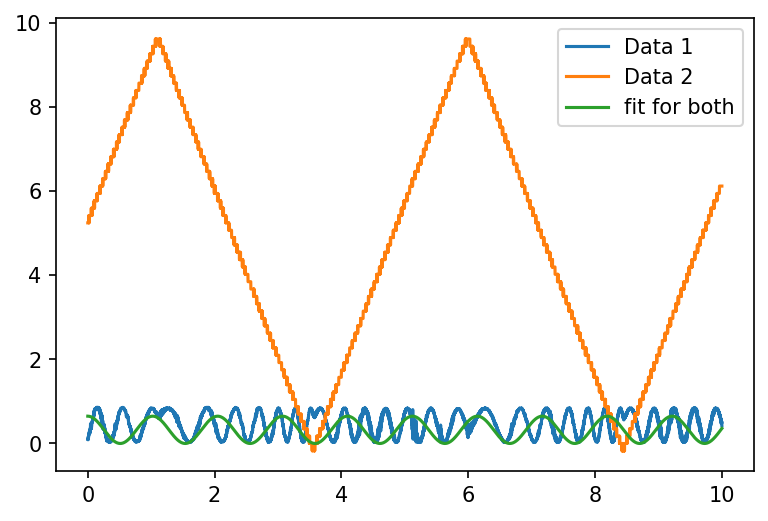

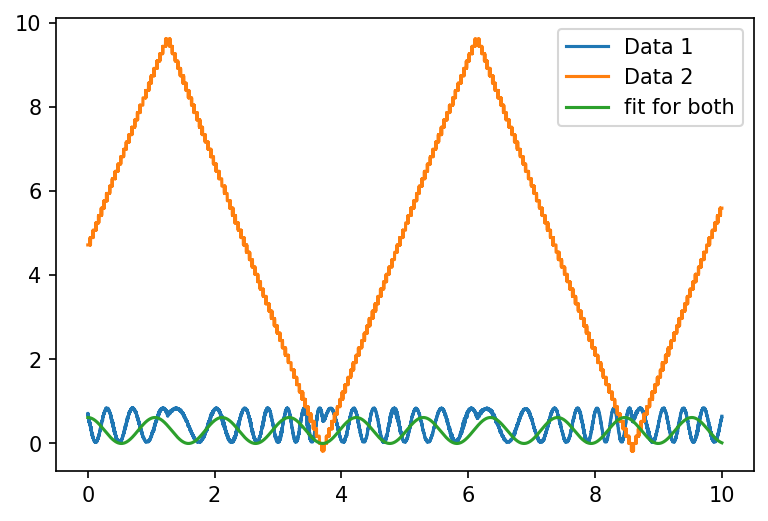

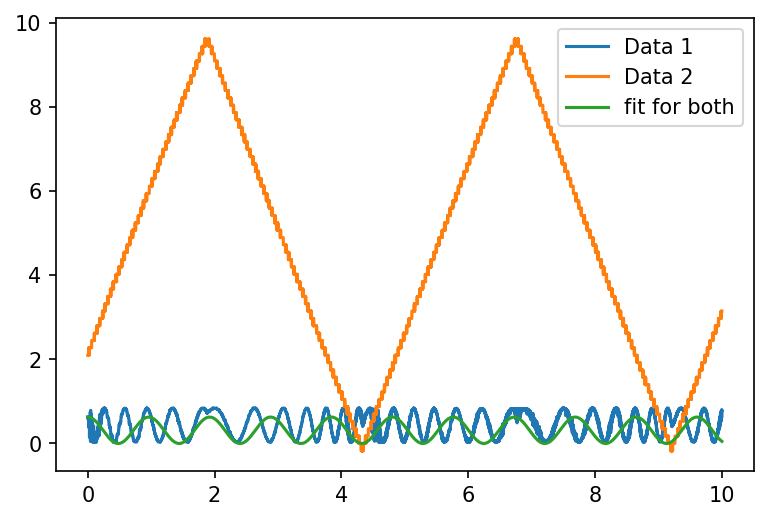

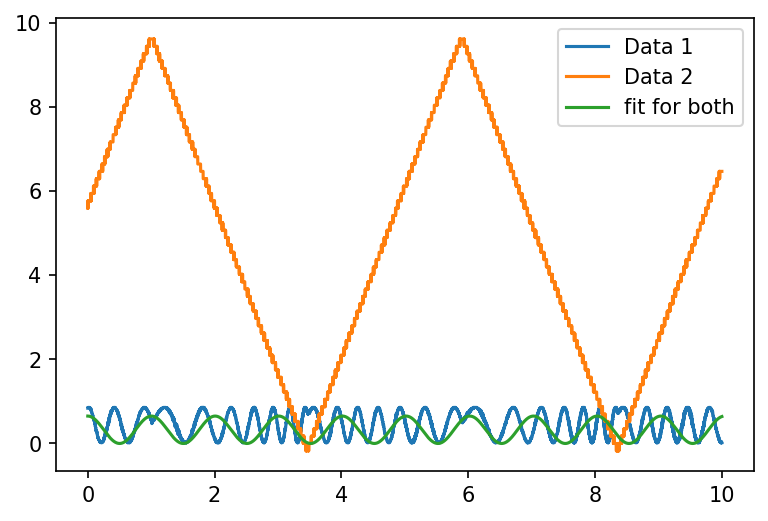

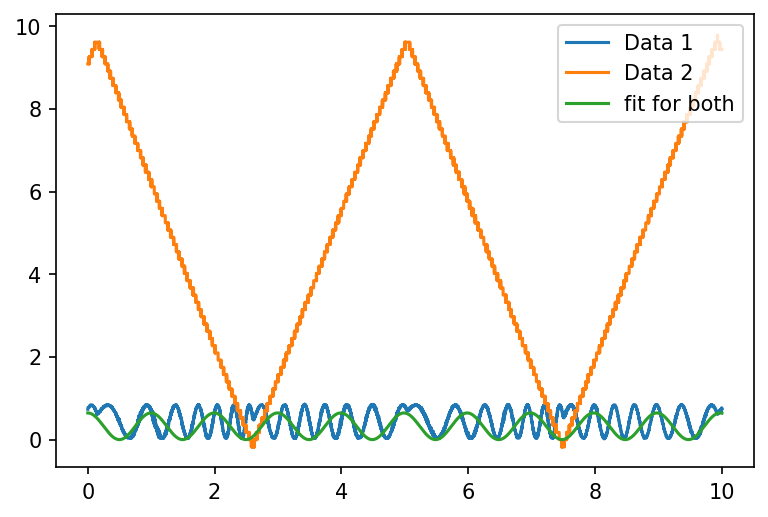

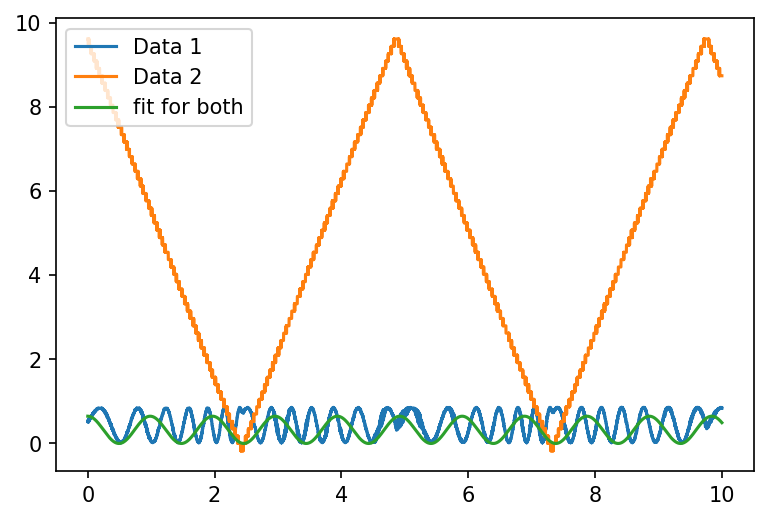

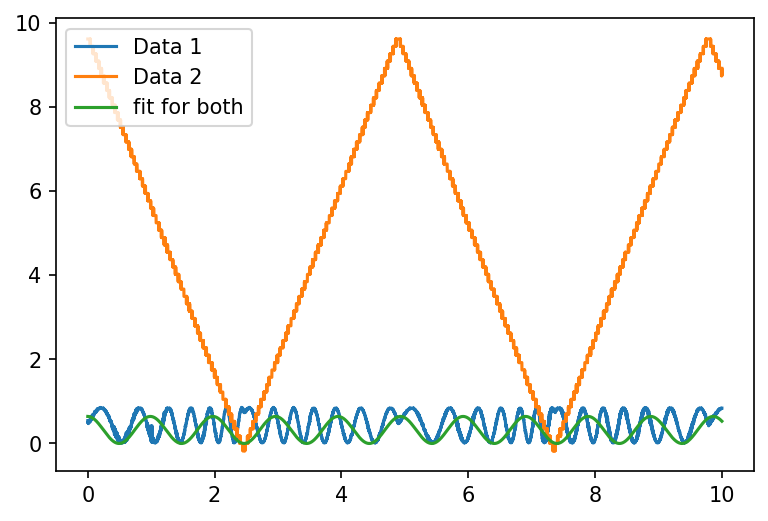

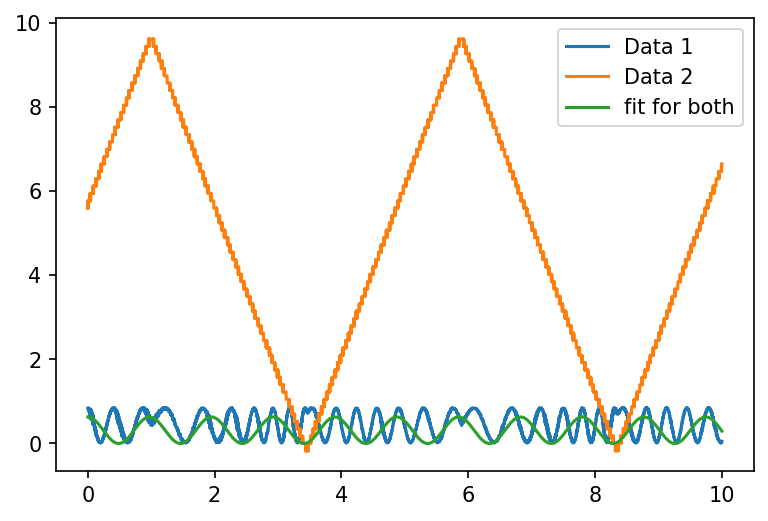

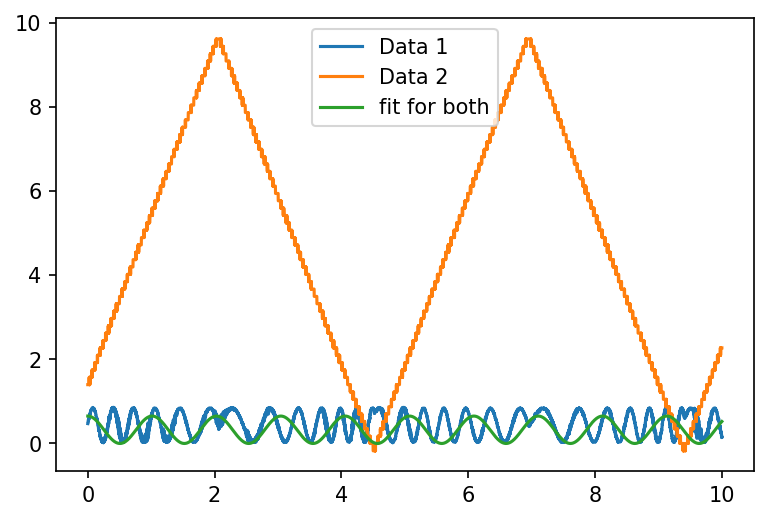

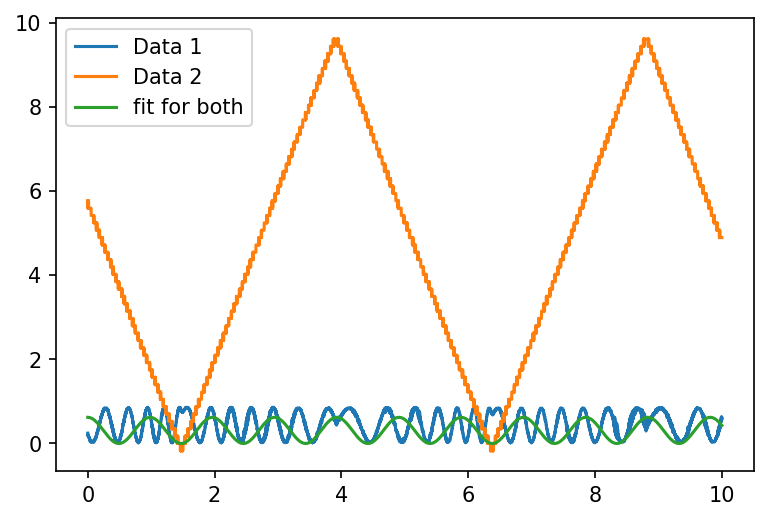

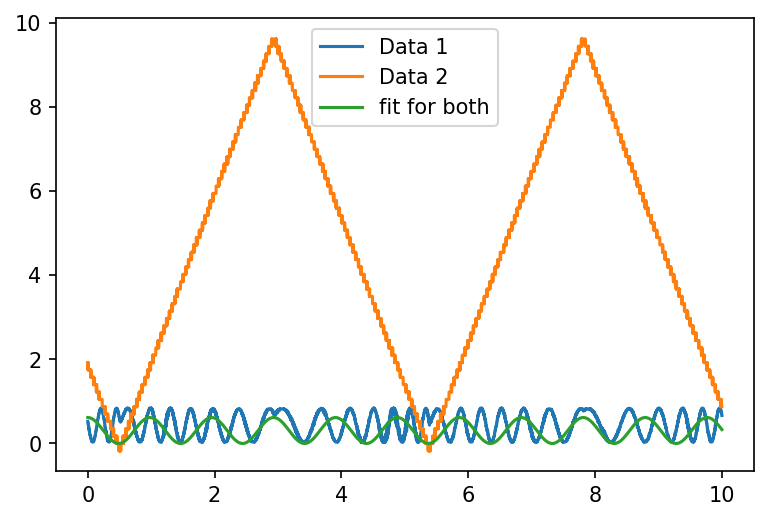

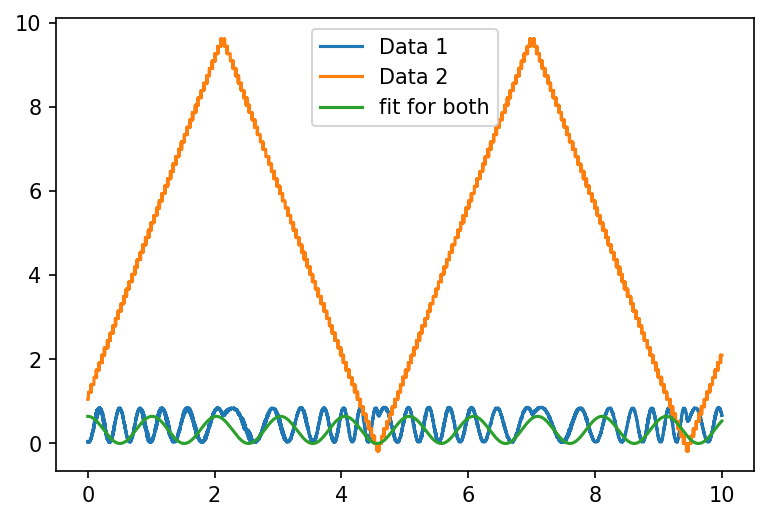

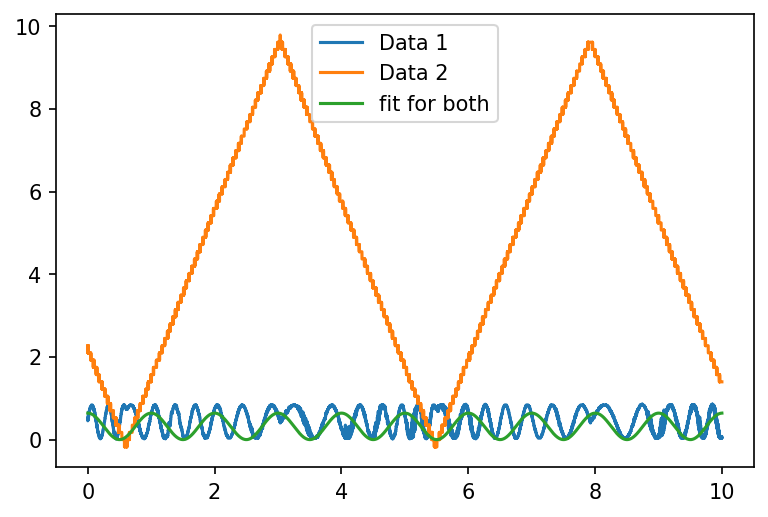

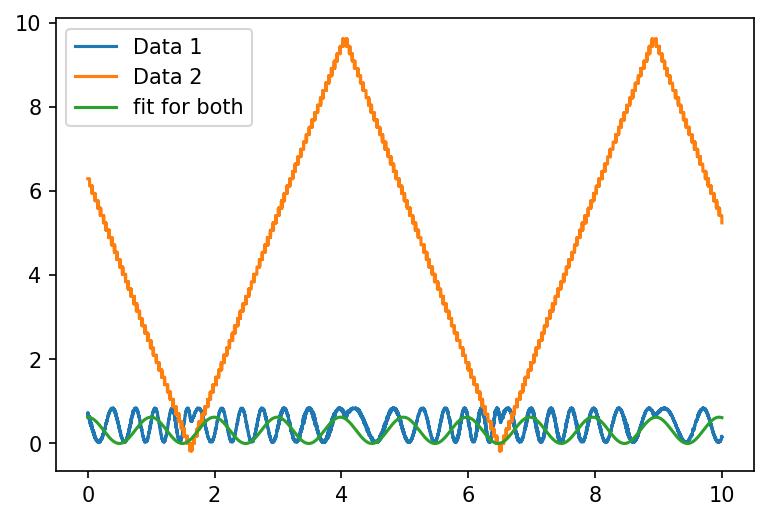

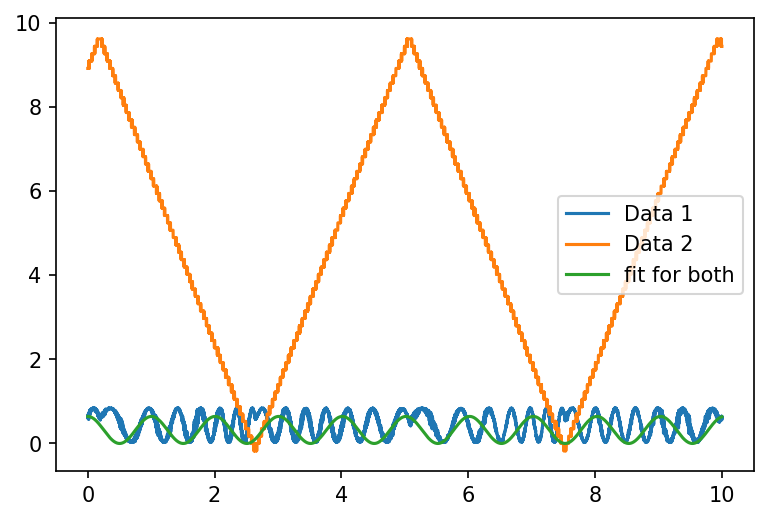

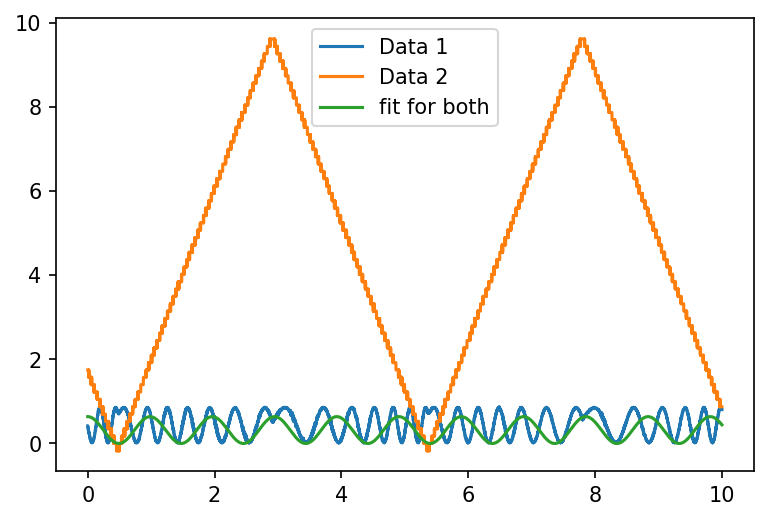

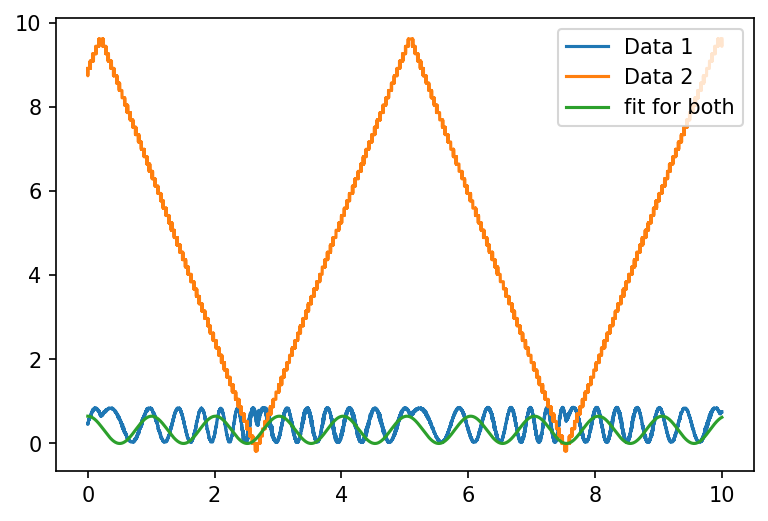

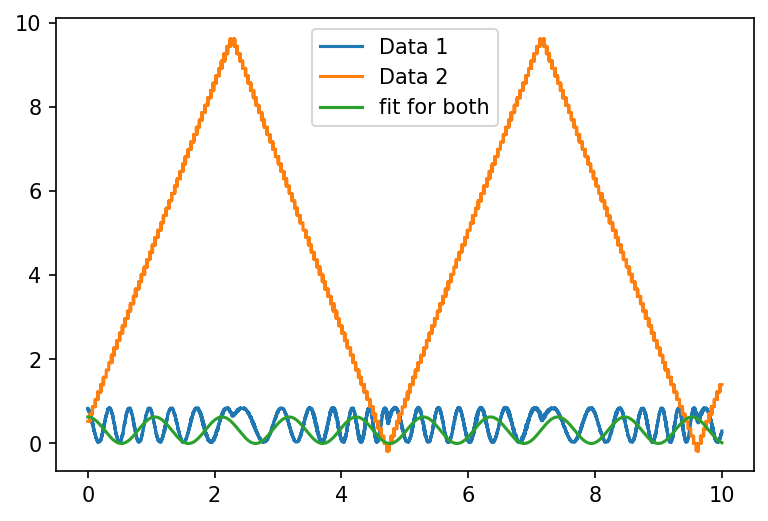

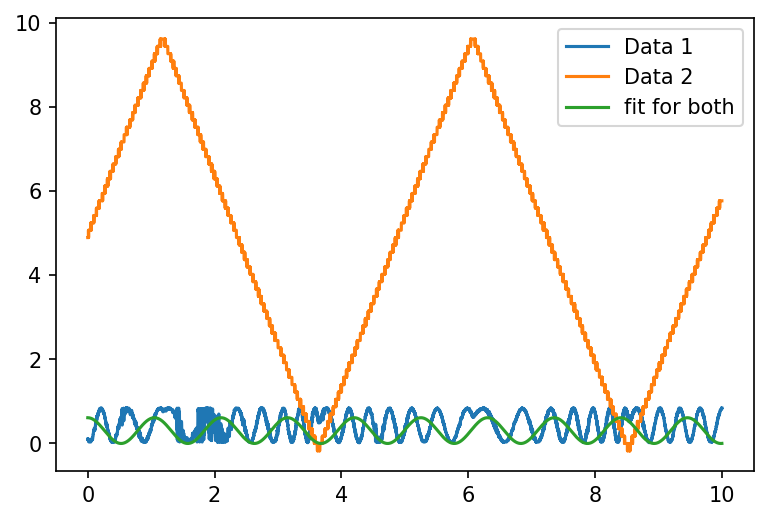

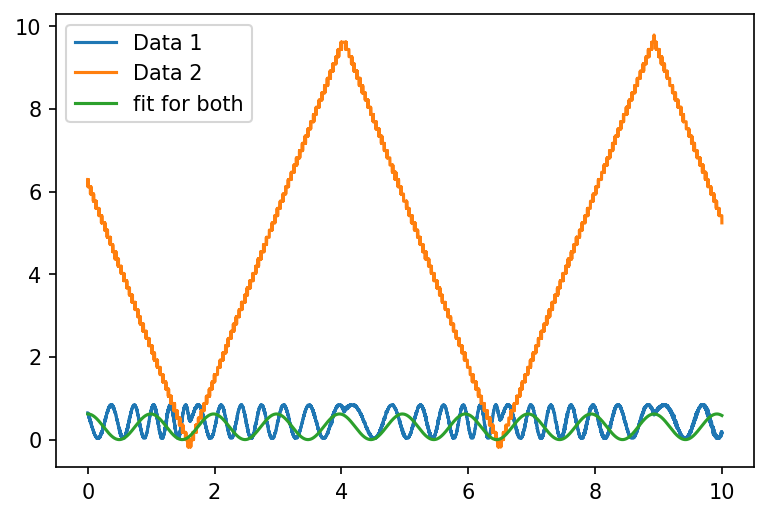

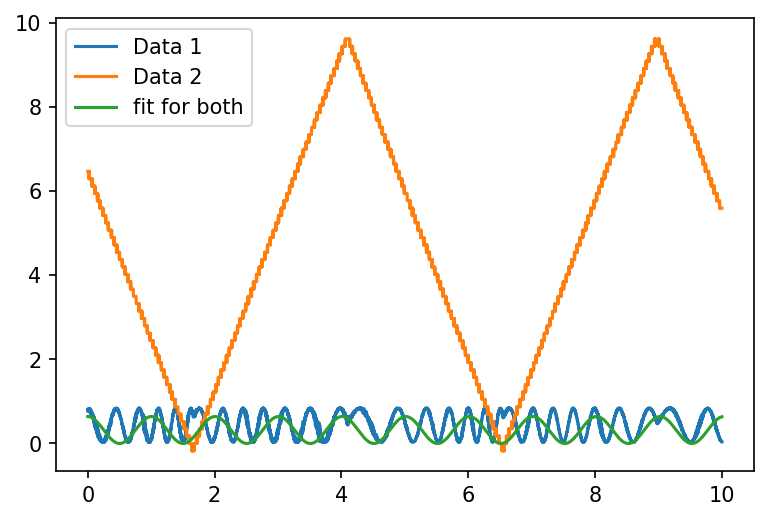

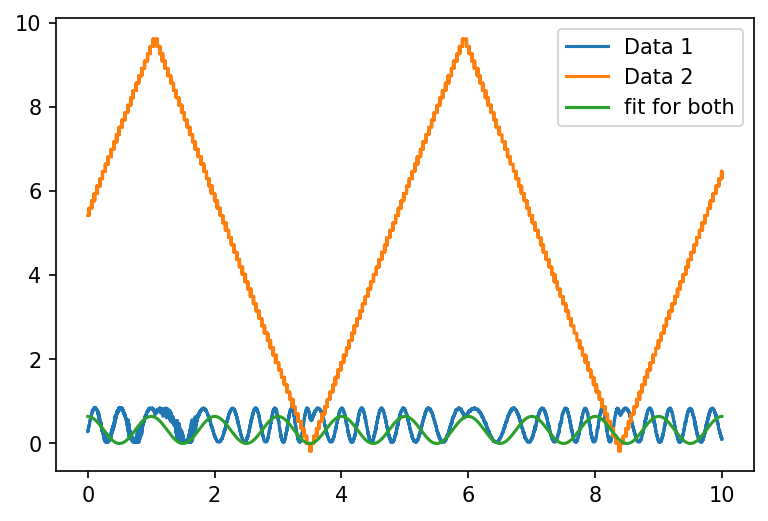

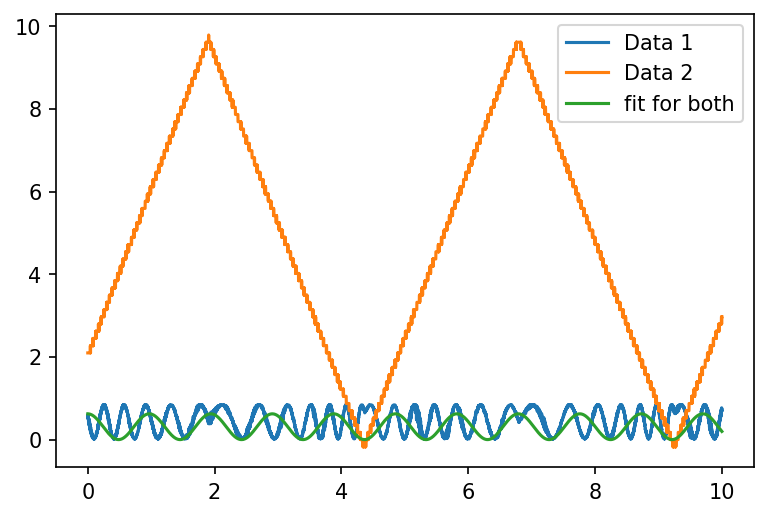

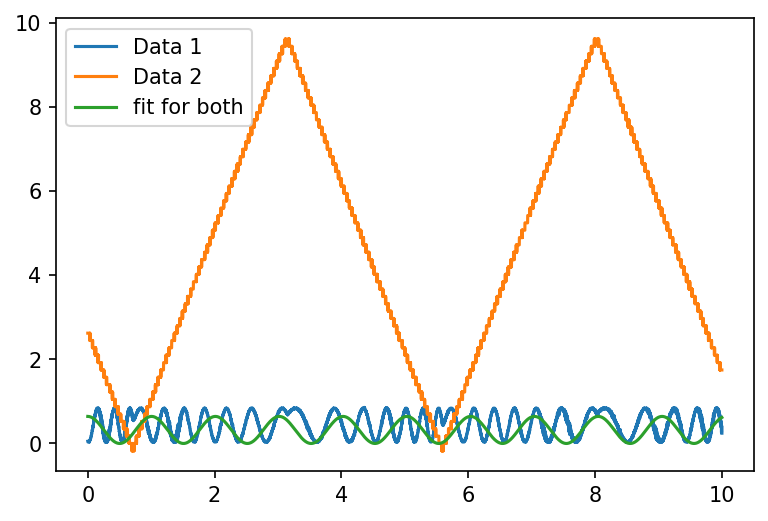

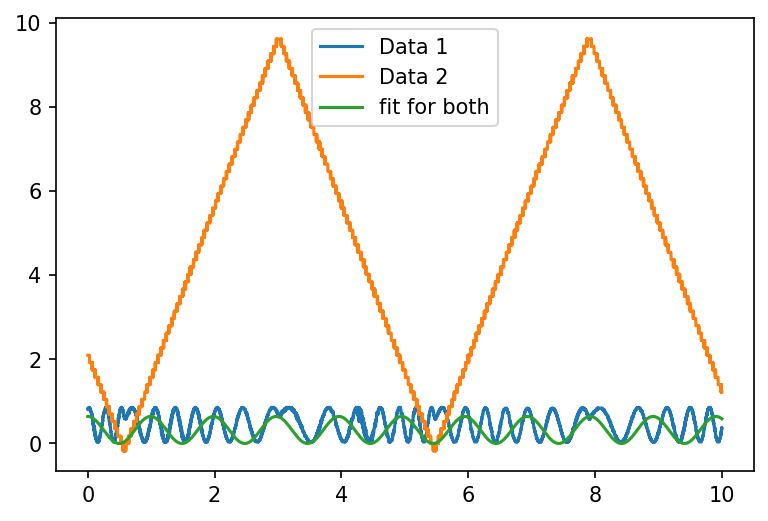

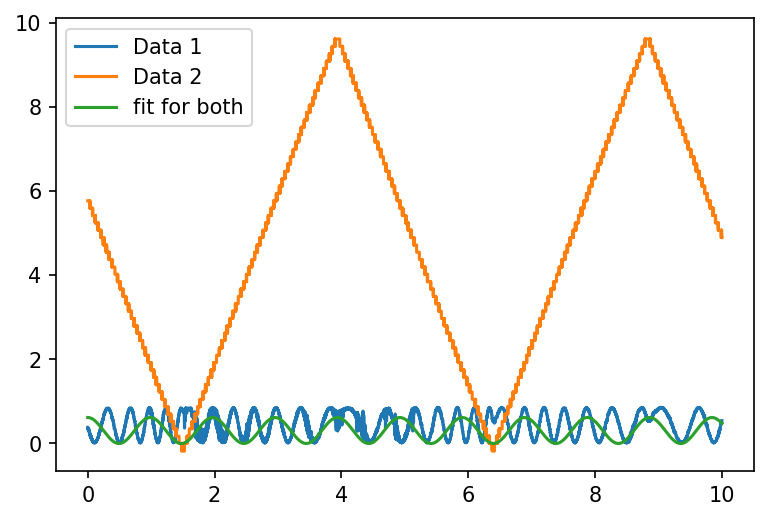

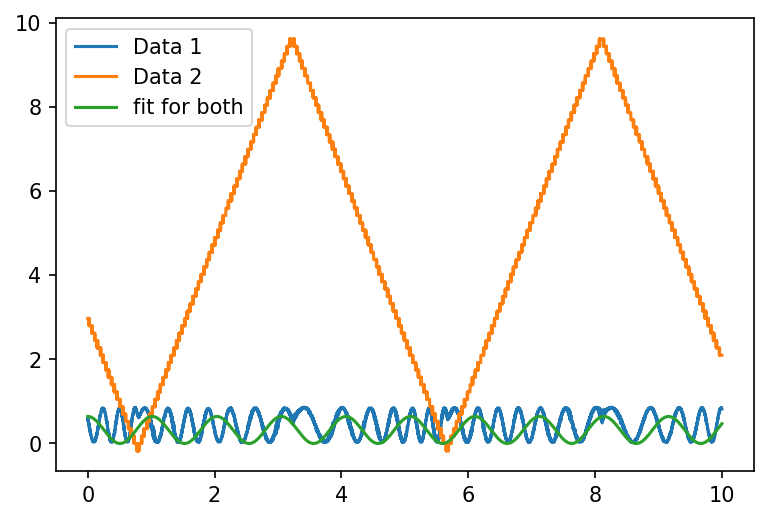

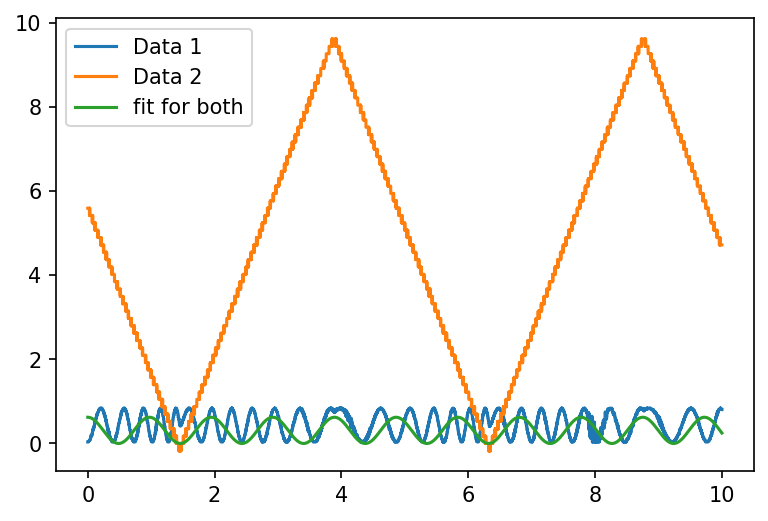

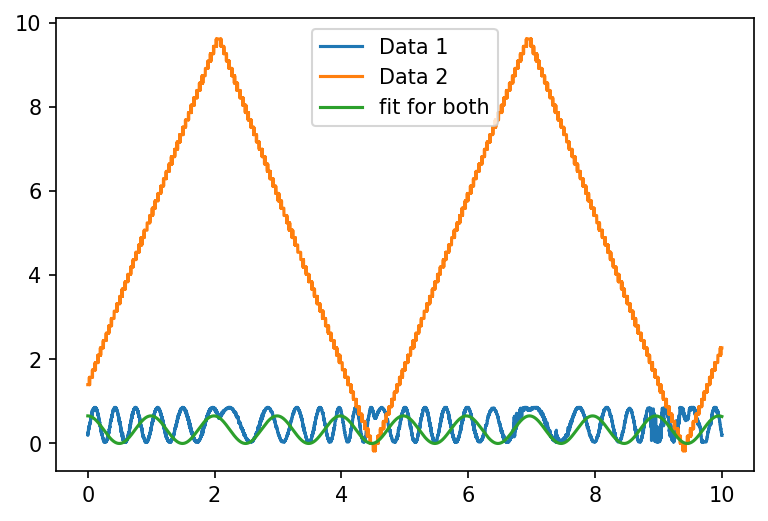

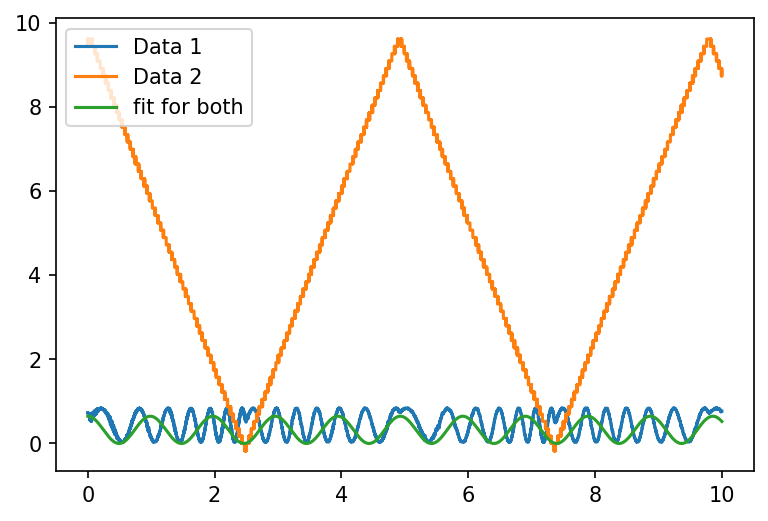

In [72]:
# Fit data to as sine function just to try something

def Intensity(ds,*p): #define fitting function
    #E0 = p[0]
    #w = p[1]
    #phi1 = p[2]
    #phi2 = p[3]
    a = p[0]
    b = p[1]
    return a * (1+np.cos(b*ds))
    #return c * eps0 * T * R * E0**2 * (np.cos(w * t + phi1) + np.cos(w * t + phi2))**2

for Data,Data_name in zip(Data_list,Data_names):
    plt.figure() #plot raw data
    Time=Data[:,0]
    V1=Data[:,1]
    V2=Data[:,2]
    plt.plot(Time, V1, '-', label='Data 1')
    plt.plot(Time,V2, label='Data 2')
    #plt.xlabel('Time [s]')
    #plt.ylabel('Voltage [V]')
    
    #Do fit to first sine wave, make guesses on amplitide with max(V1)-min(V1), make guess based on frequency written in Data_name float(Data_name[24:27])
    popt1, pcov1 = sp.curve_fit(Intensity, Time, V1, p0 = [a_guess, b_guess]) #add them together (v1+v2) to see how the combined wave
    plt.plot(Time, Intensity(Time ,*popt1),'-',label='fit for both')
    
    plt.legend()
    
    

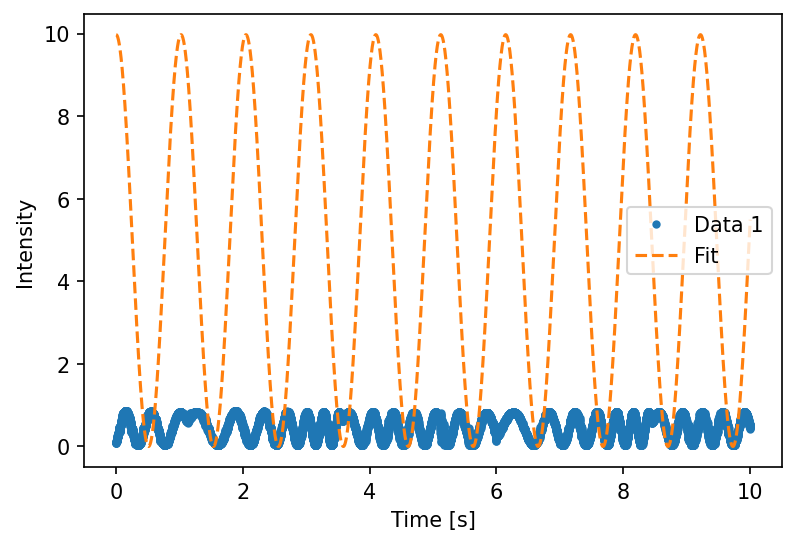

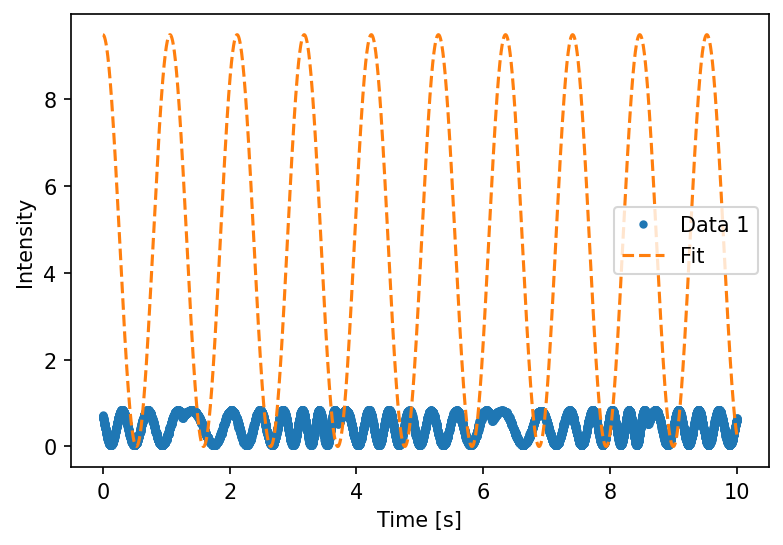

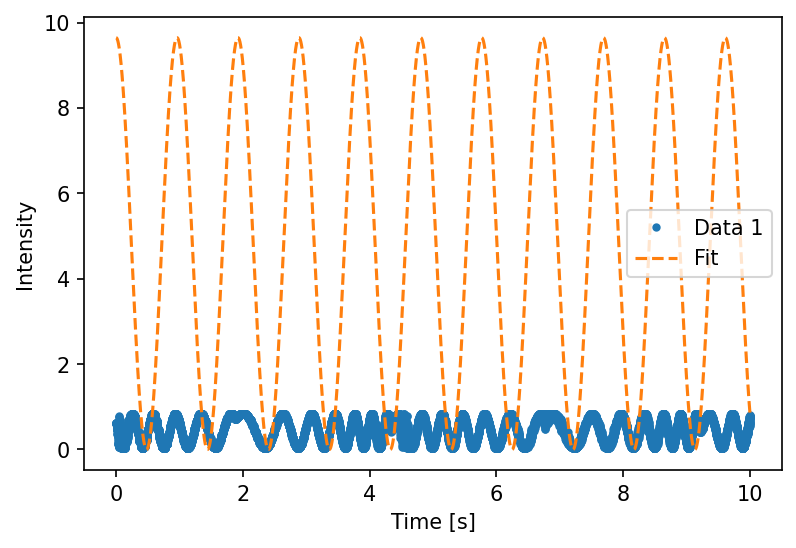

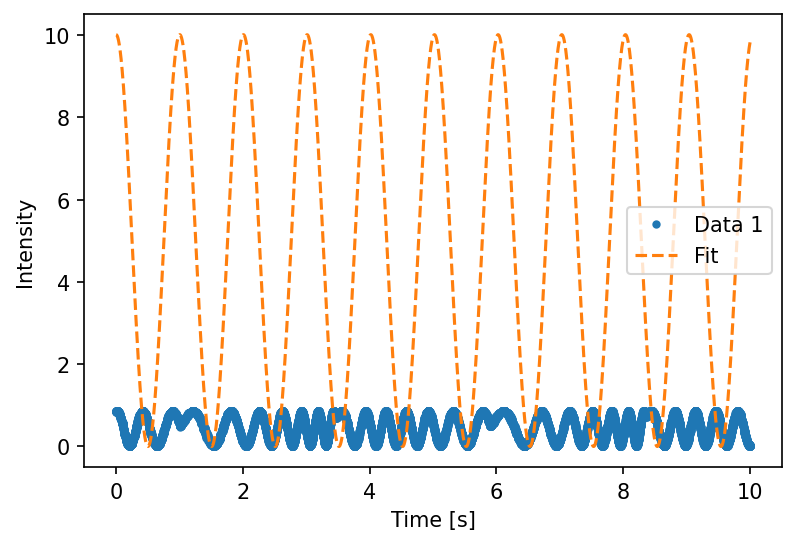

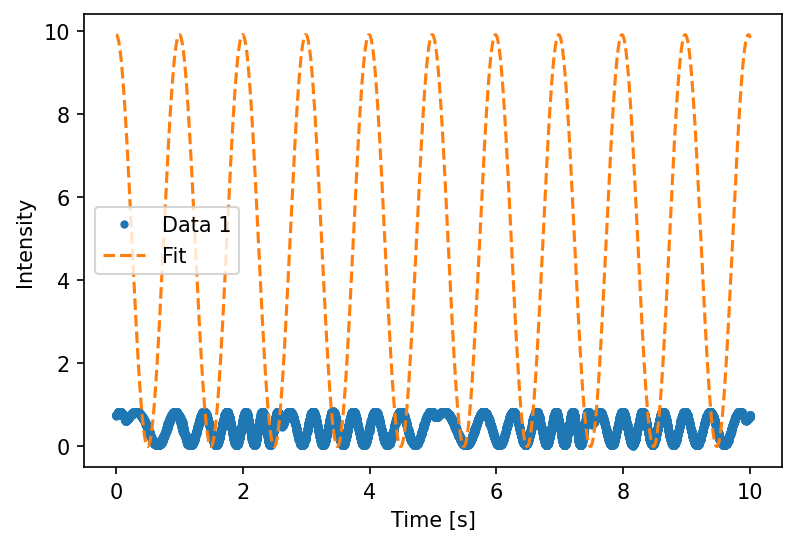

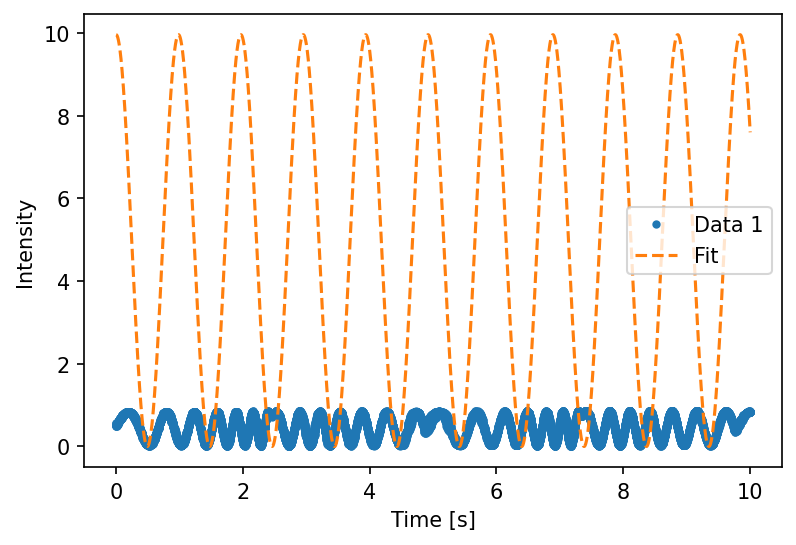

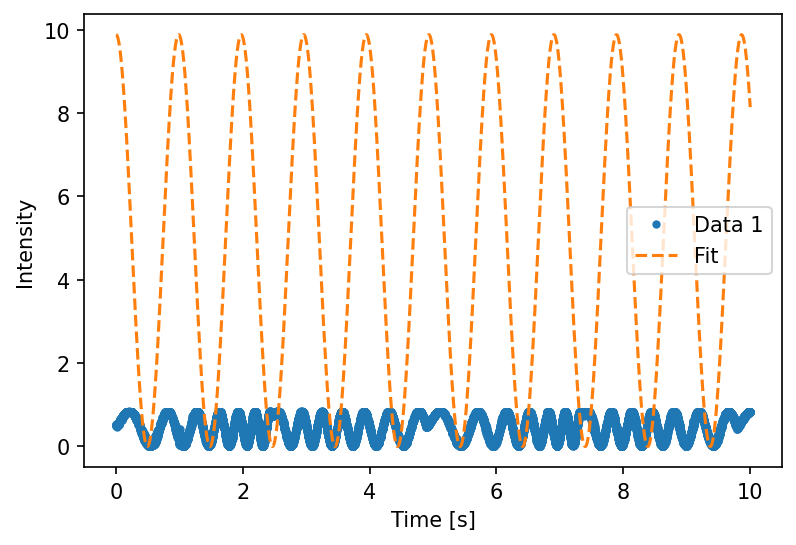

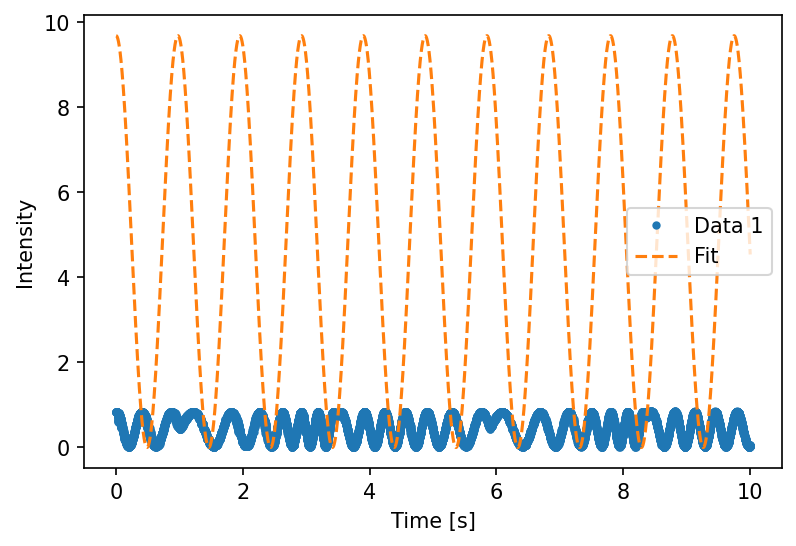

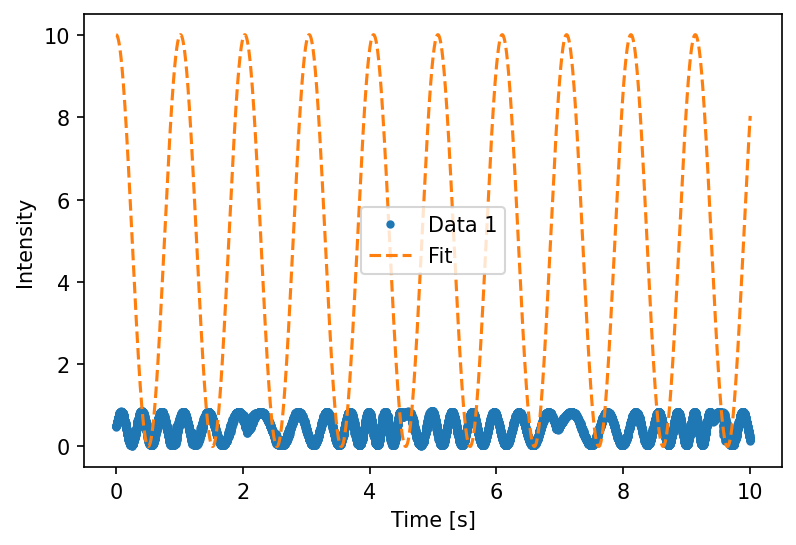

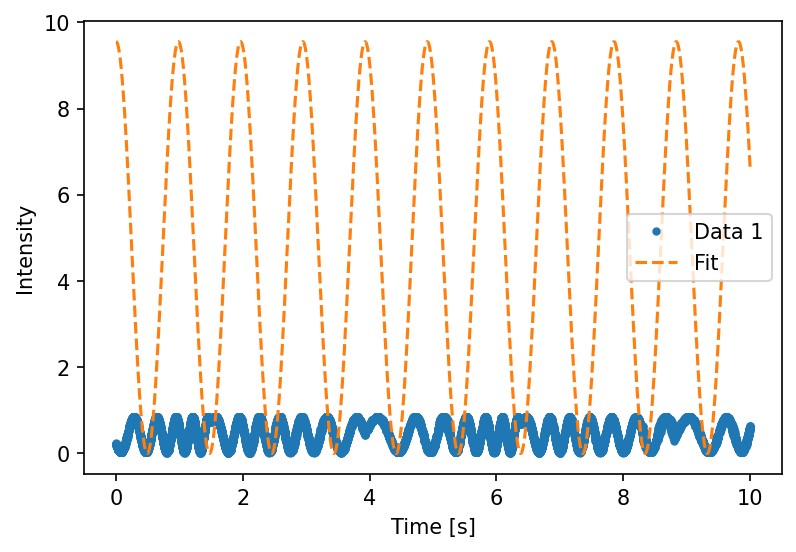

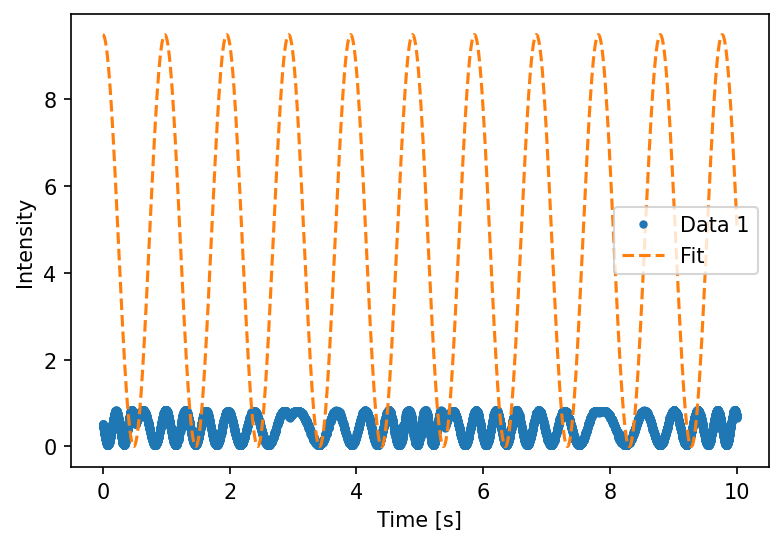

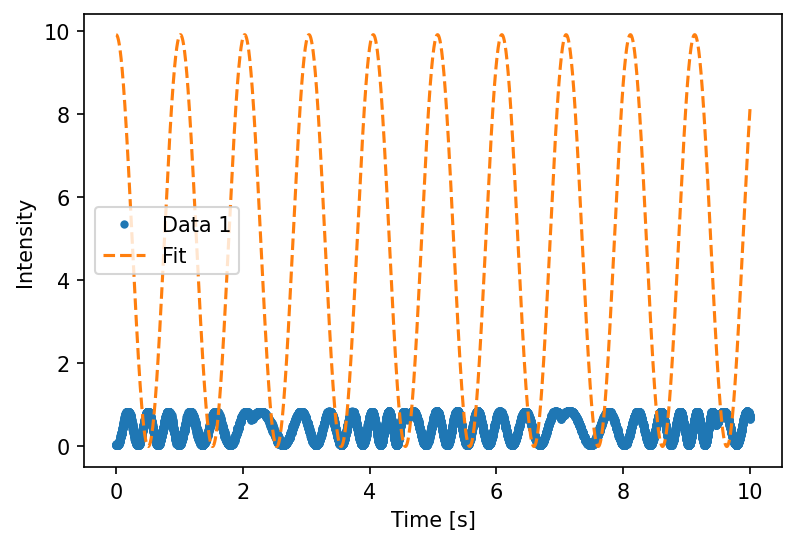

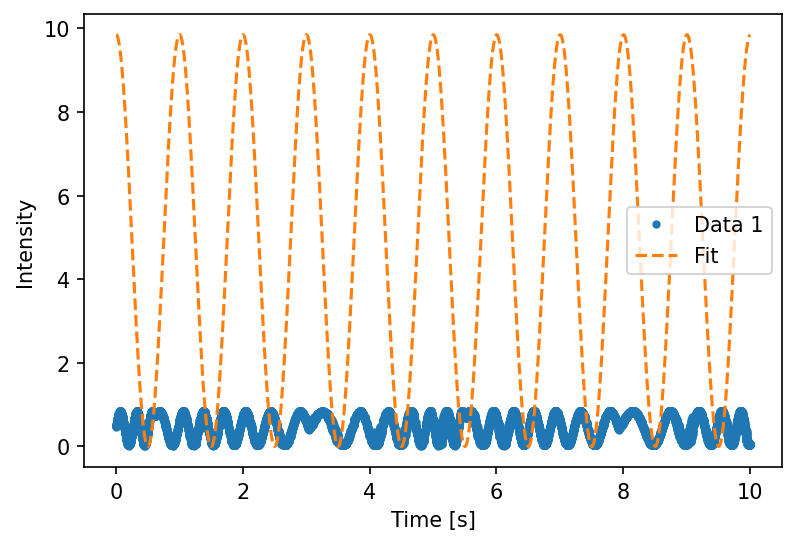

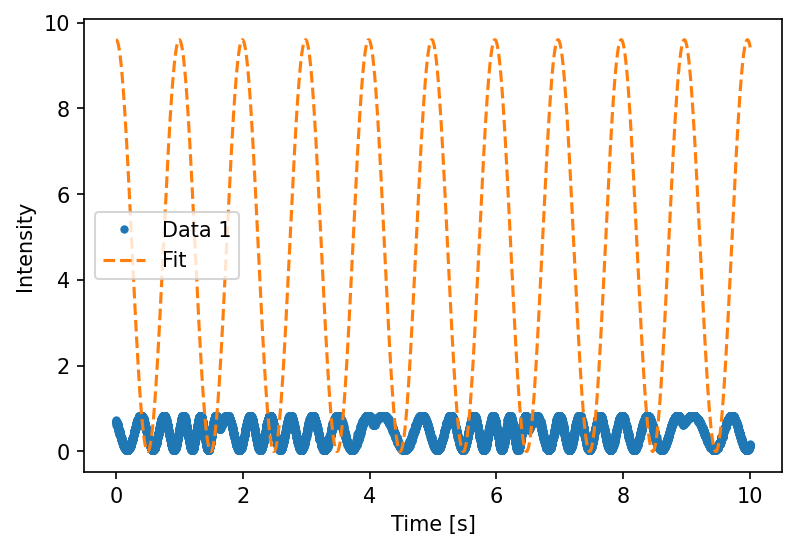

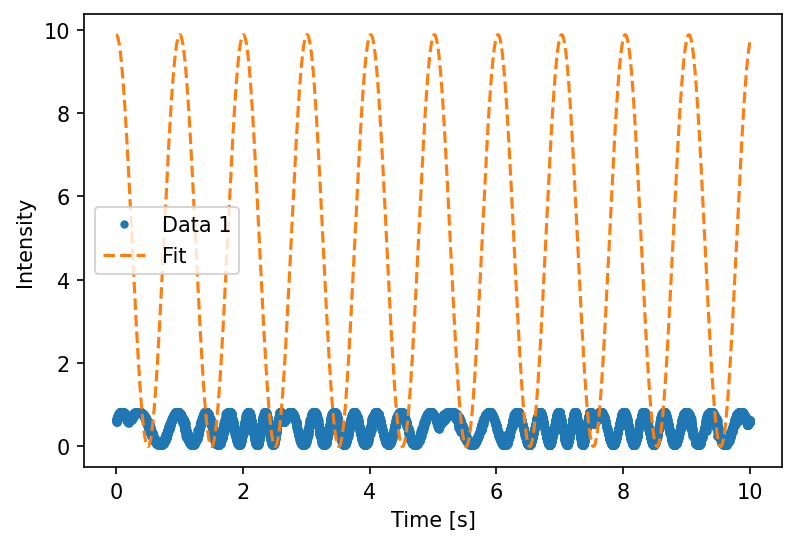

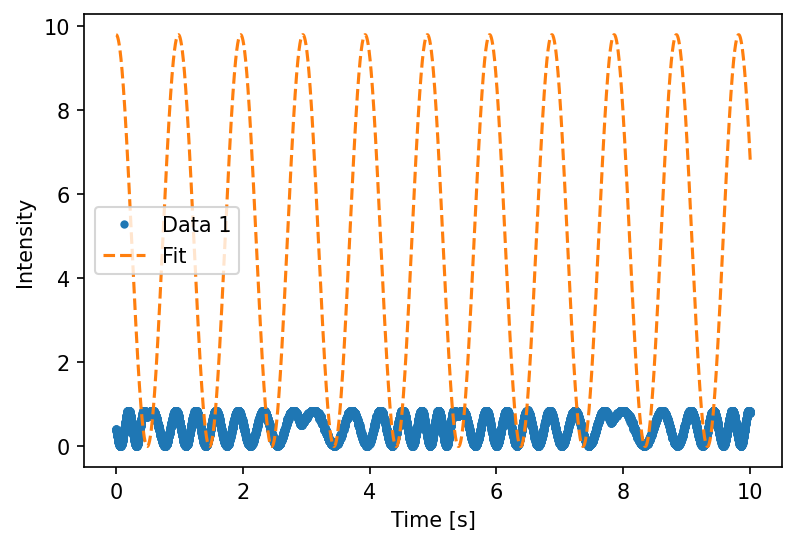

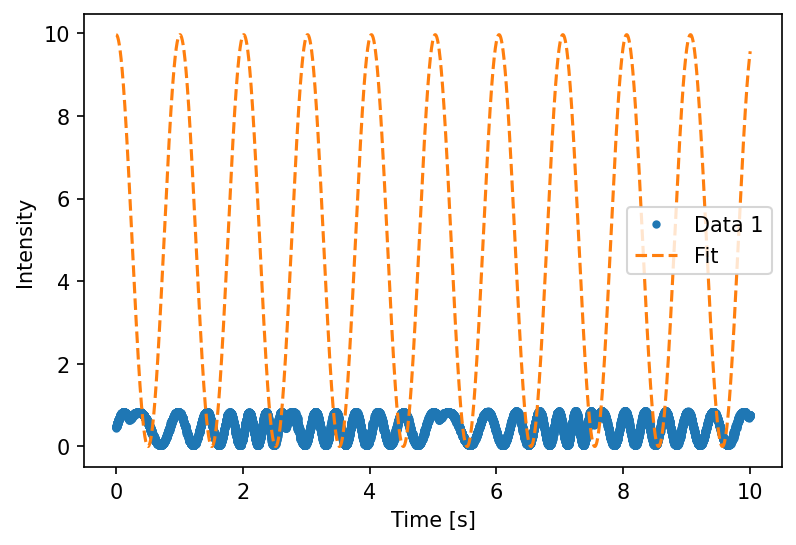

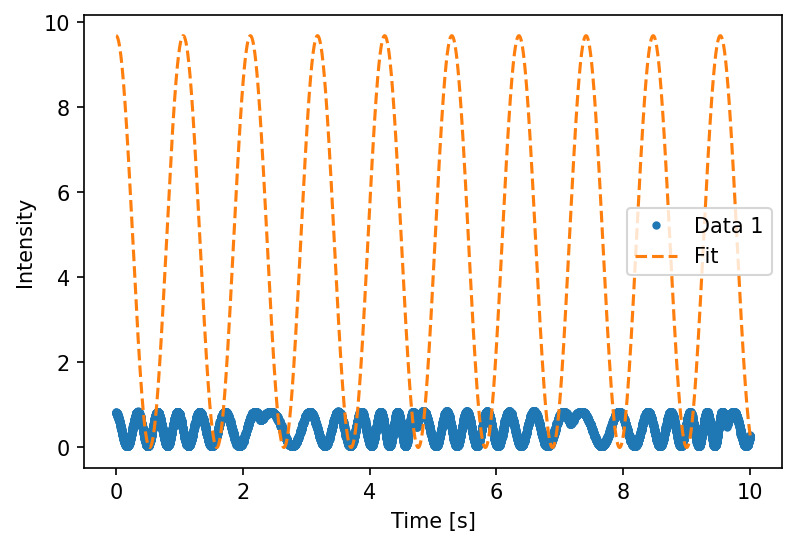

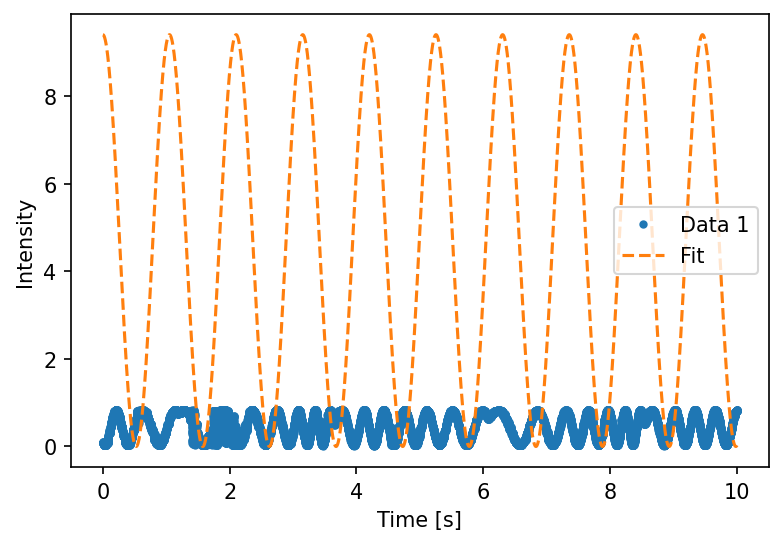

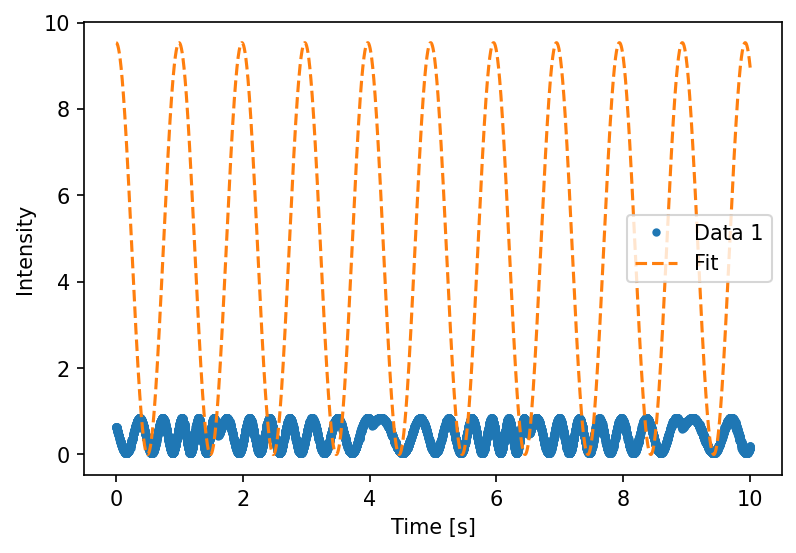

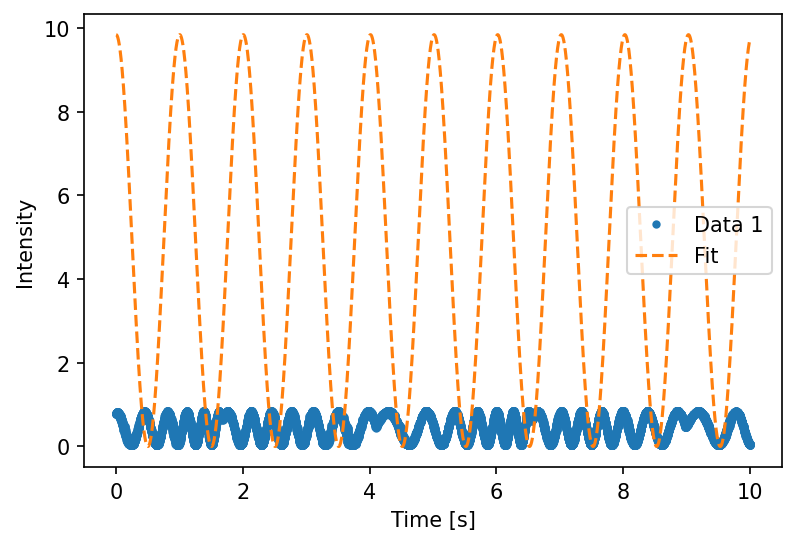

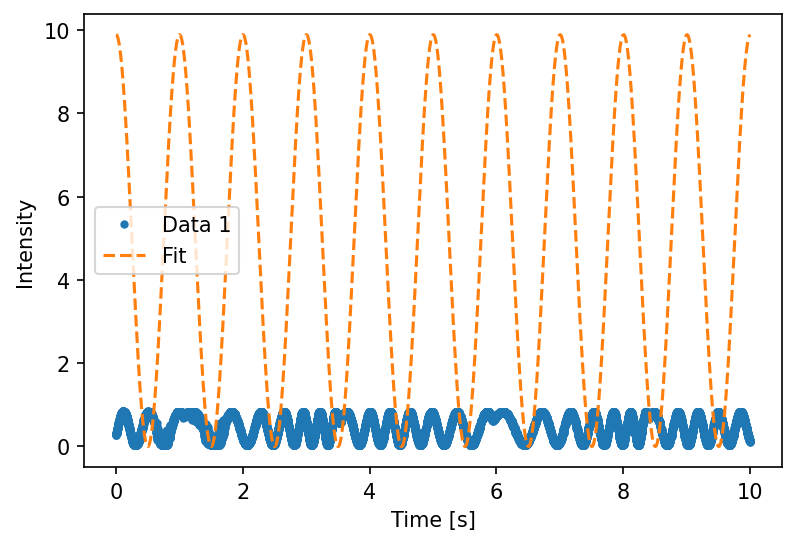

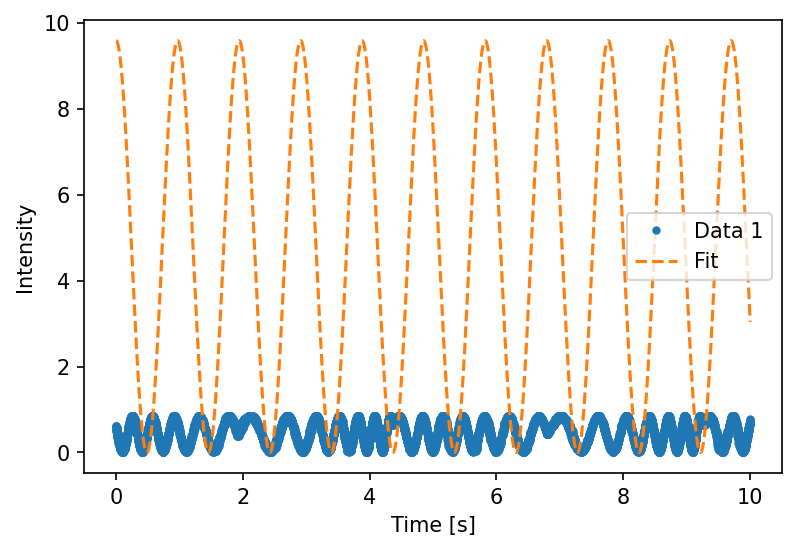

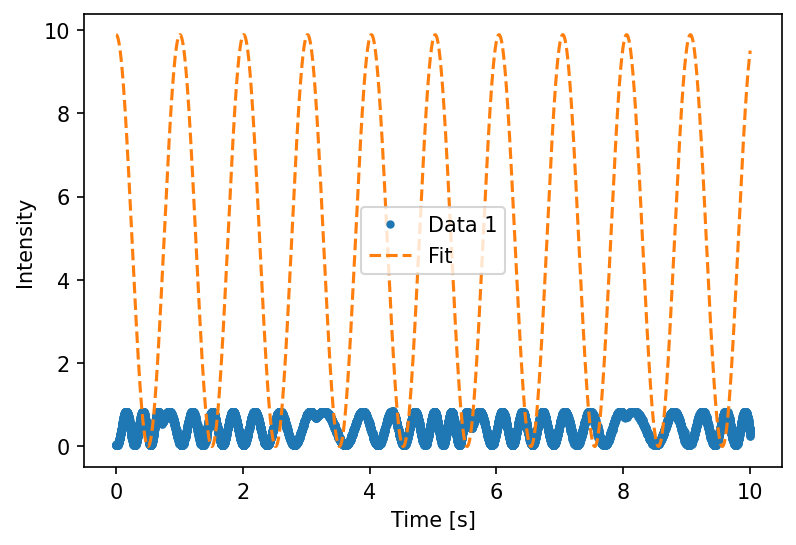

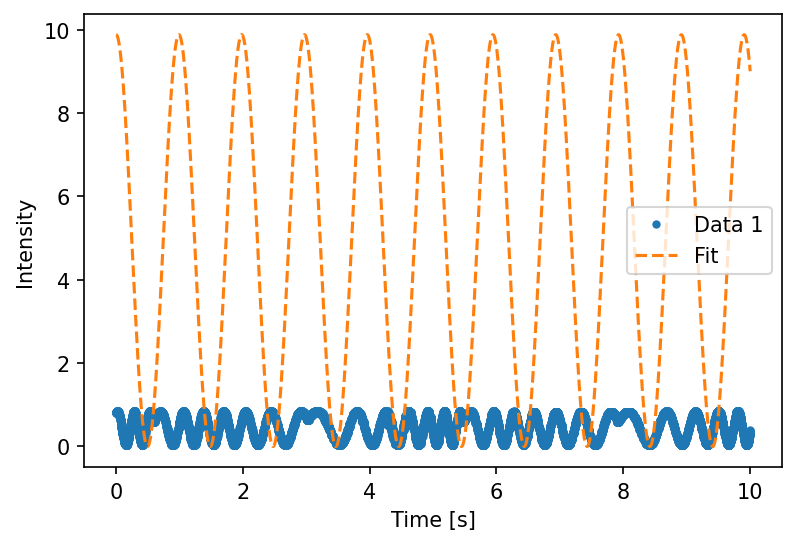

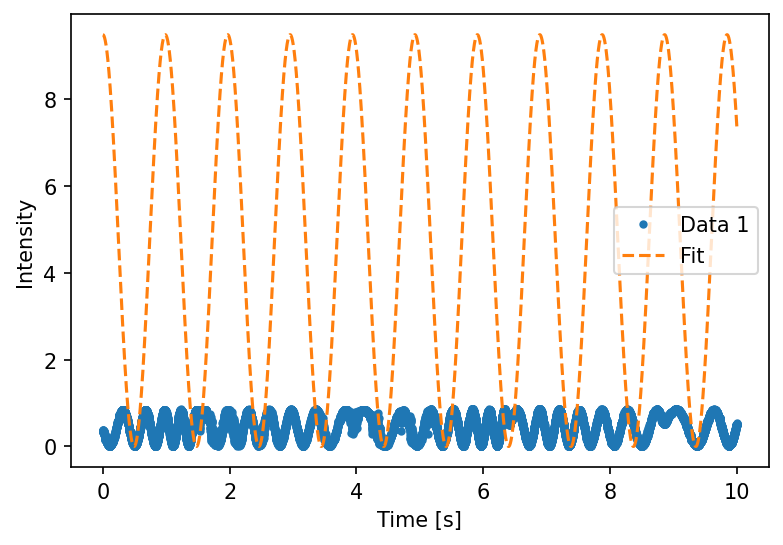

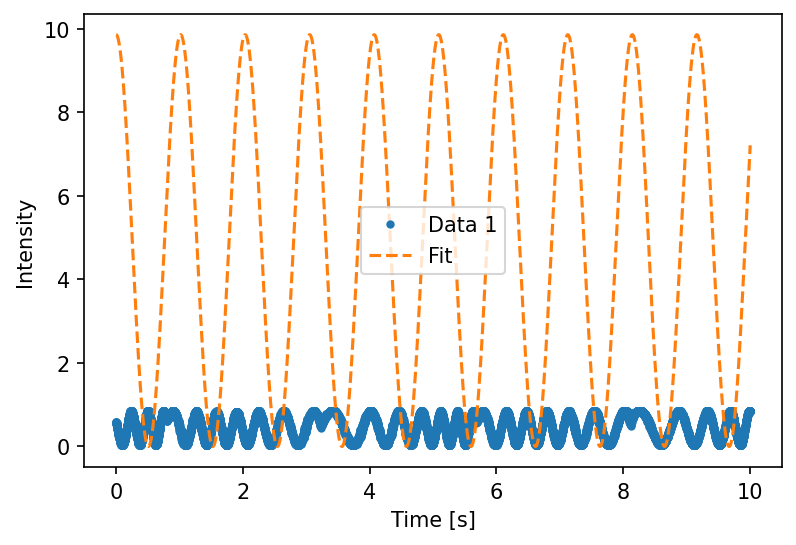

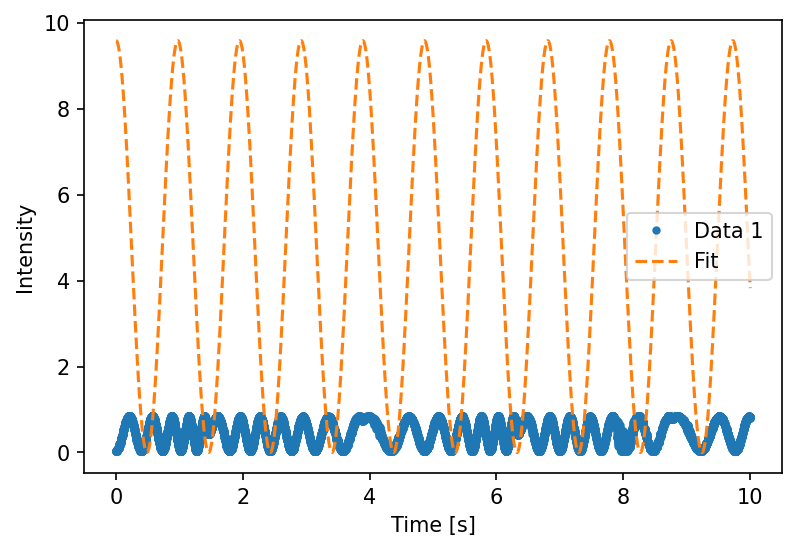

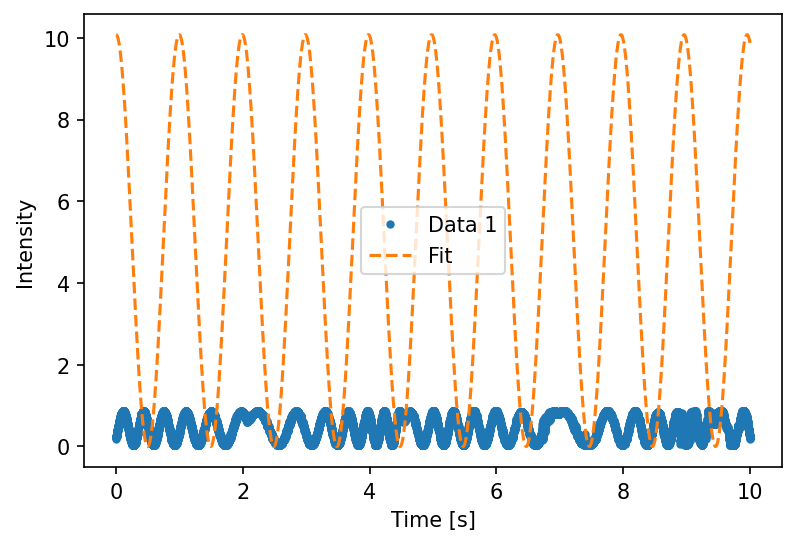

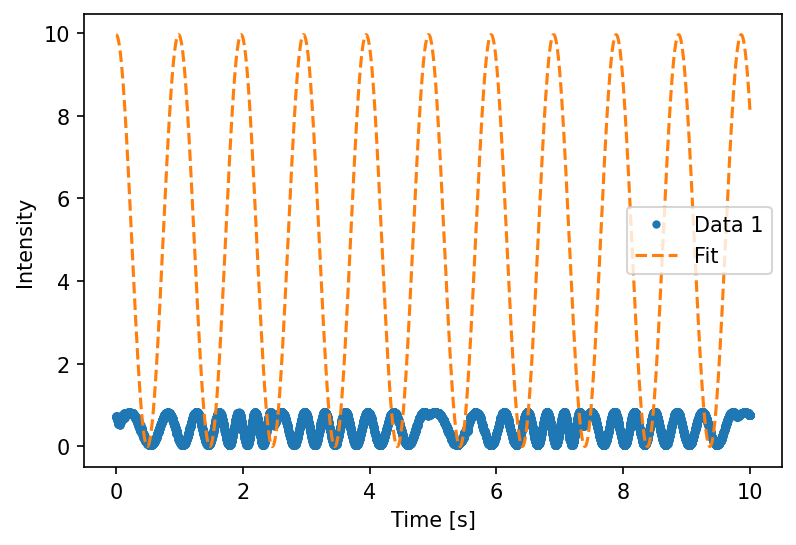

In [73]:
# Normalize data
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Initial guess function for frequency and phase
def initial_guess(data):
    normalized_data = normalize(data[:, 1])
    # Guess frequency based on the full spectrum of frequencies
    freqs = np.fft.fftfreq(len(data[:, 0]), data[1, 0] - data[0, 0])
    fft_values = np.fft.fft(normalized_data)
    dominant_freq_index = np.argmax(np.abs(fft_values[1:])) + 1
    dominant_freq = freqs[dominant_freq_index]
    
    # Refine phase guess using autocorrelation
    autocorr = np.correlate(normalized_data, normalized_data, mode='full')
    phase_guess = np.argmax(autocorr) * (data[1, 0] - data[0, 0]) * 2 * np.pi
    
    return [max(data[:, 1]) - min(data[:, 1]), abs(dominant_freq), phase_guess, 0]

popt_list = []
pcov_list = []

for Data, Data_name in zip(Data_list, Data_names):
    plt.plot(Data[:, 0], Data[:, 1], '.', label='Data 1')

    try:
        # Perform the fit with initial guesses for parameters
        popt, pcov = sp.curve_fit(Intensity, Data[:, 0], Data[:, 1], p0=[a_guess, b_guess]) #initial_guess(Data))
        popt_list.append(popt)
        pcov_list.append(pcov)

        # Plot the fitted curve
        plt.plot(Data[:, 0], Intensity(Data[:, 0], *popt)/a_guess, '--', label='Fit')

        plt.xlabel('Time [s]')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()
        
    except RuntimeError:
        print(f"Optimal parameters not found for dataset: {Data_name}. Skipping...")
        continue


In [74]:
np.sqrt(pcov_list)

/tmp/ipykernel_7016/4279833894.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(pcov_list)


array([[[0.0025674 , 0.0001566 ],
        [0.0001566 , 0.00234173]],

       [[0.00254019, 0.00039594],
        [0.00039594, 0.00245834]],

       [[0.00247498, 0.00036121],
        [0.00036121, 0.0023523 ]],

       [[0.00259121,        nan],
        [       nan, 0.00236597]],

       [[0.00253524,        nan],
        [       nan, 0.00237509]],

       [[0.00251407,        nan],
        [       nan, 0.00237606]],

       [[0.00250061,        nan],
        [       nan, 0.00238417]],

       [[0.00250107, 0.00024562],
        [0.00024562, 0.0024014 ]],

       [[0.00254113,        nan],
        [       nan, 0.00229067]],

       [[0.00252436,        nan],
        [       nan, 0.00248365]],

       [[0.00247713, 0.00018885],
        [0.00018885, 0.00243932]],

       [[0.00259283,        nan],
        [       nan, 0.00236204]],

       [[0.00252478,        nan],
        [       nan, 0.00236284]],

       [[0.00252606,        nan],
        [       nan, 0.00245008]],

       [[0.00255324,

/tmp/ipykernel_7016/505026816.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure() #plot raw data


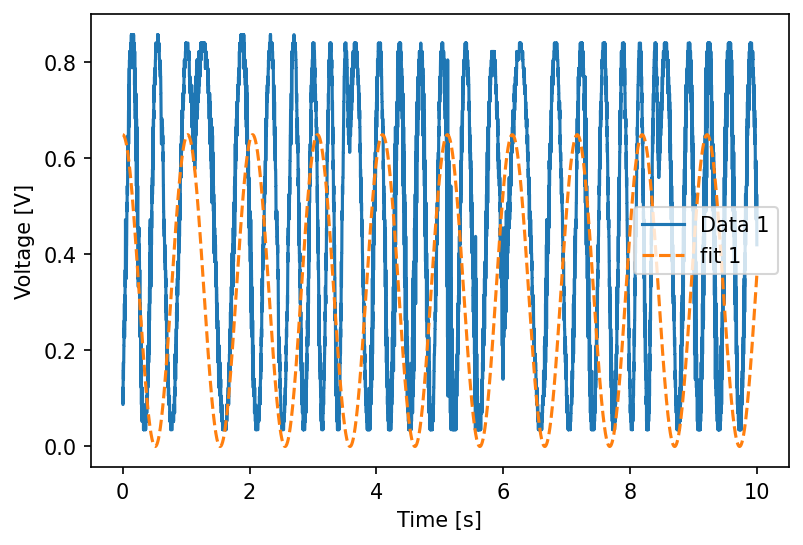

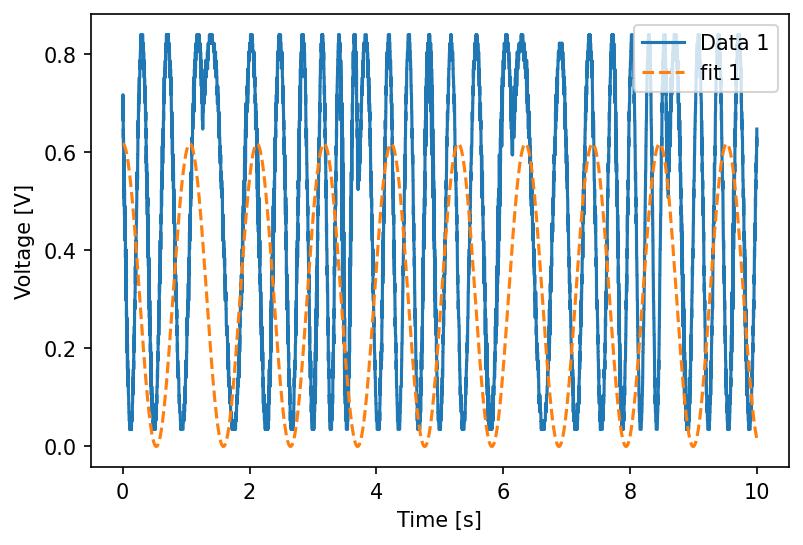

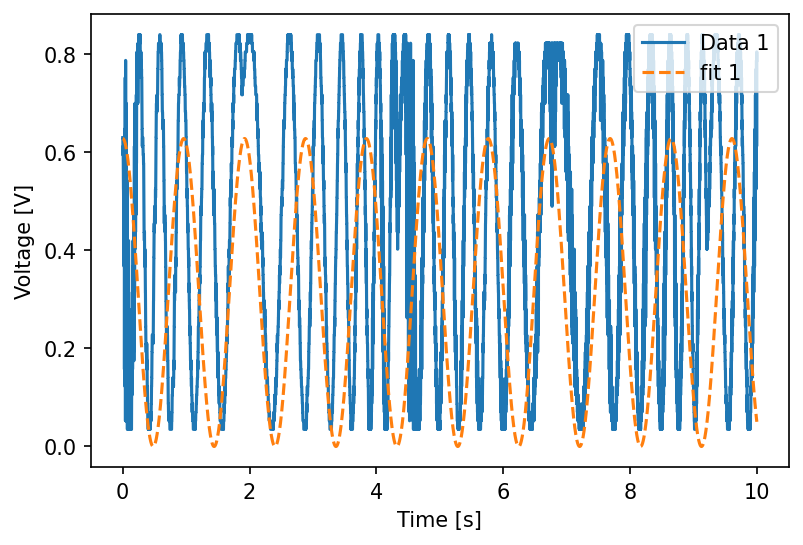

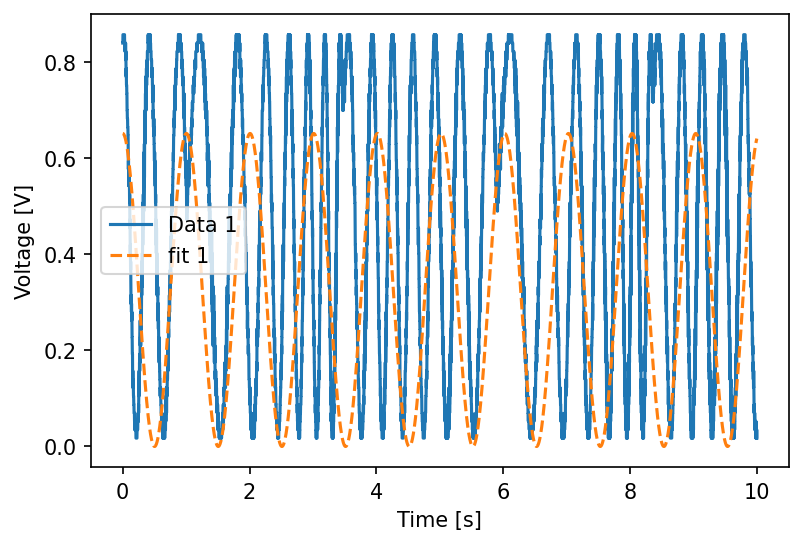

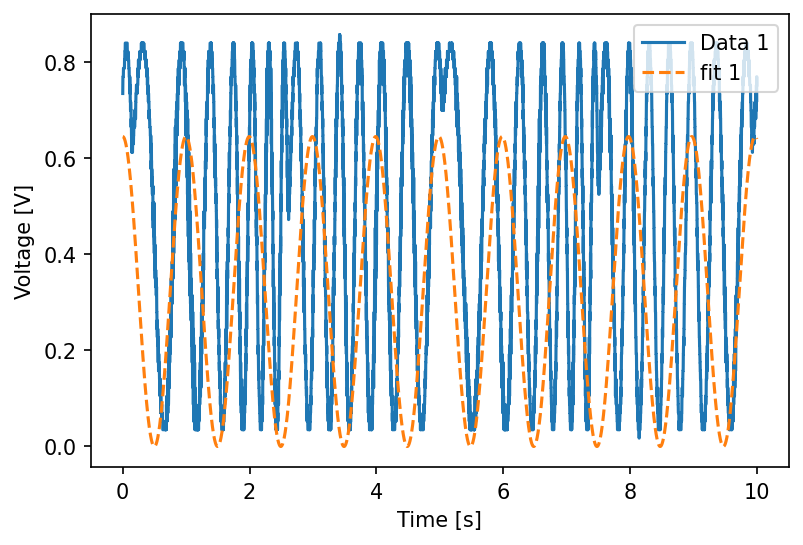

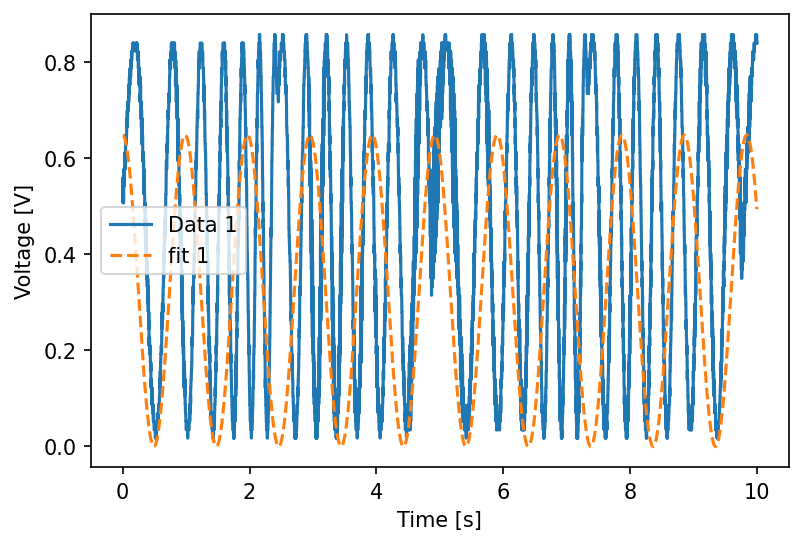

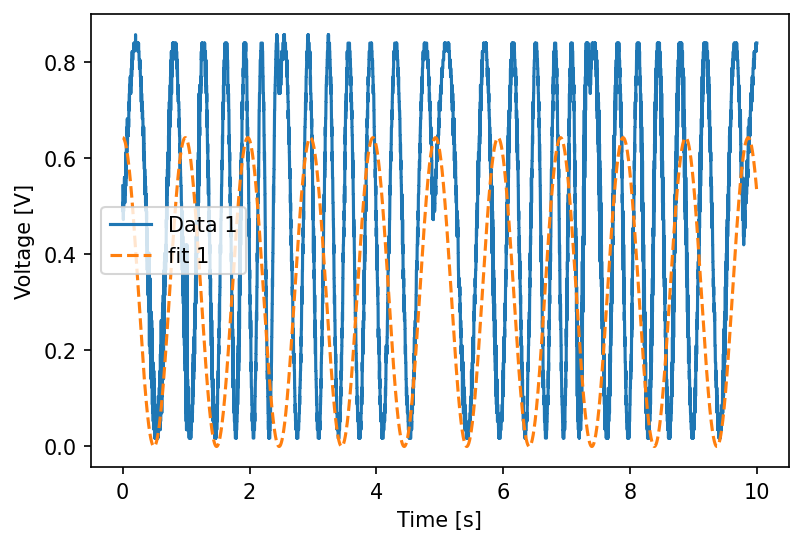

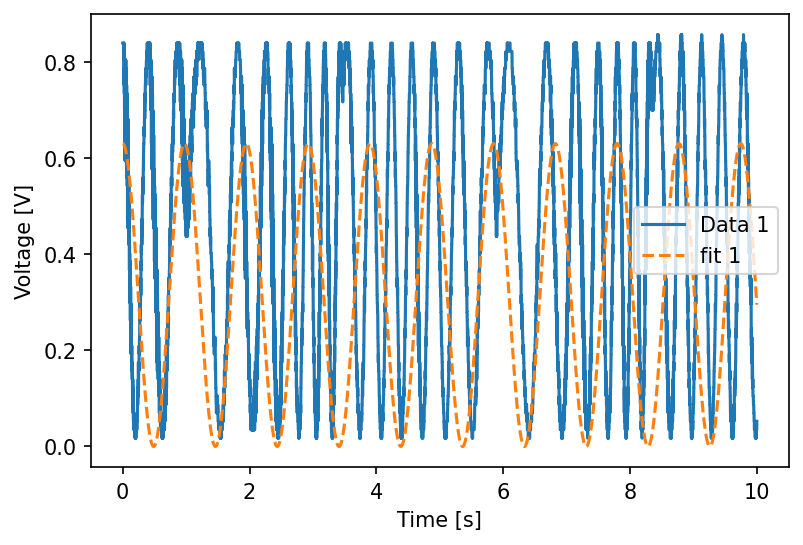

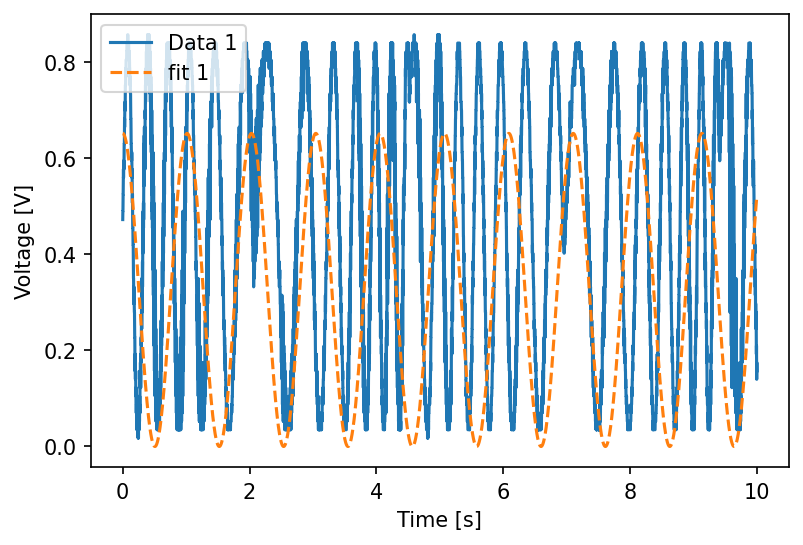

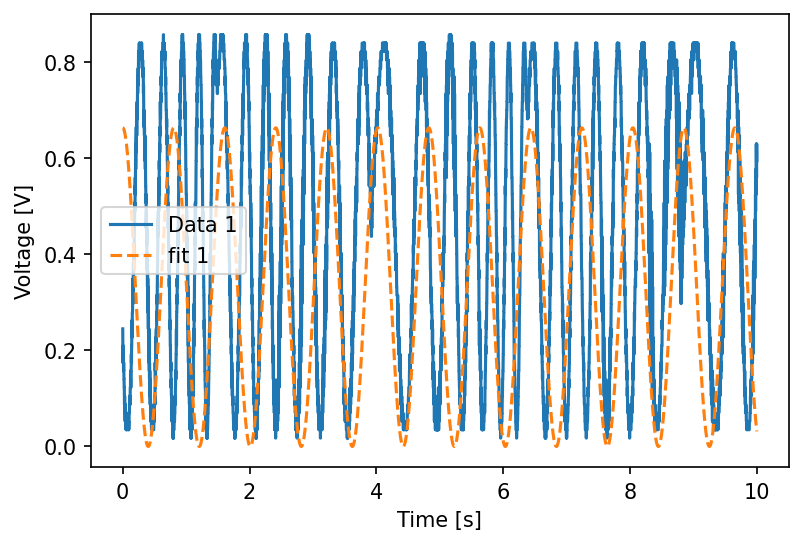

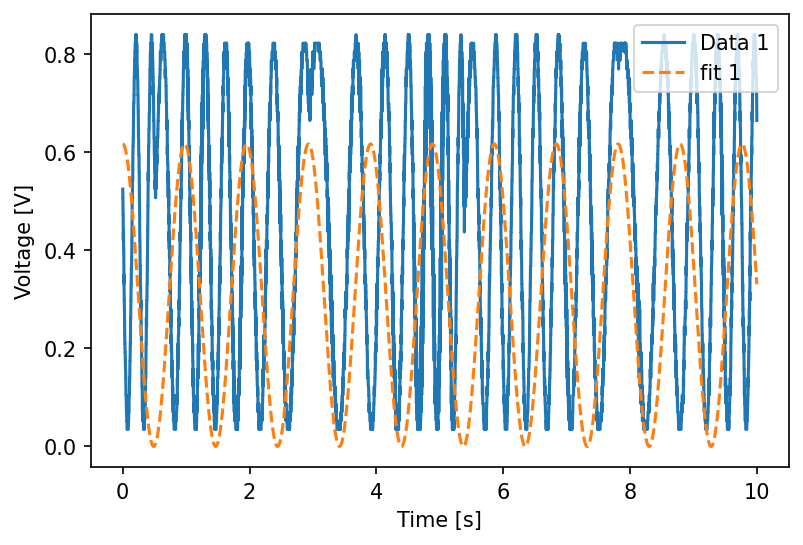

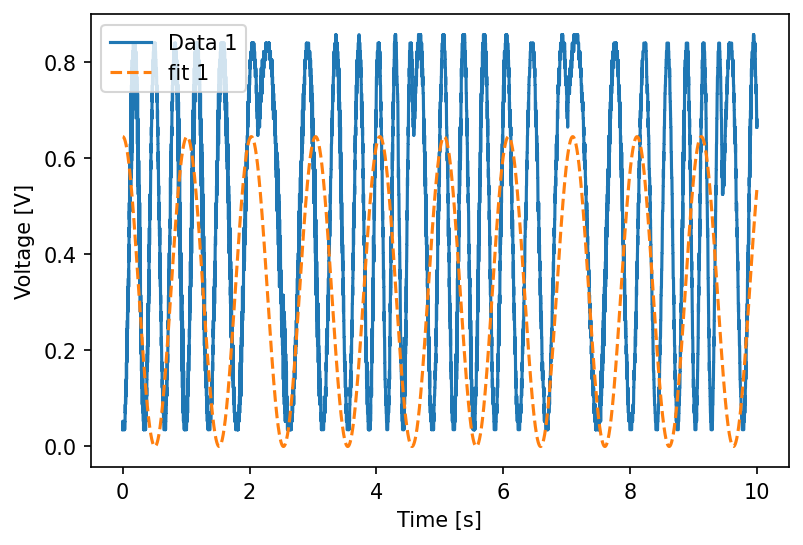

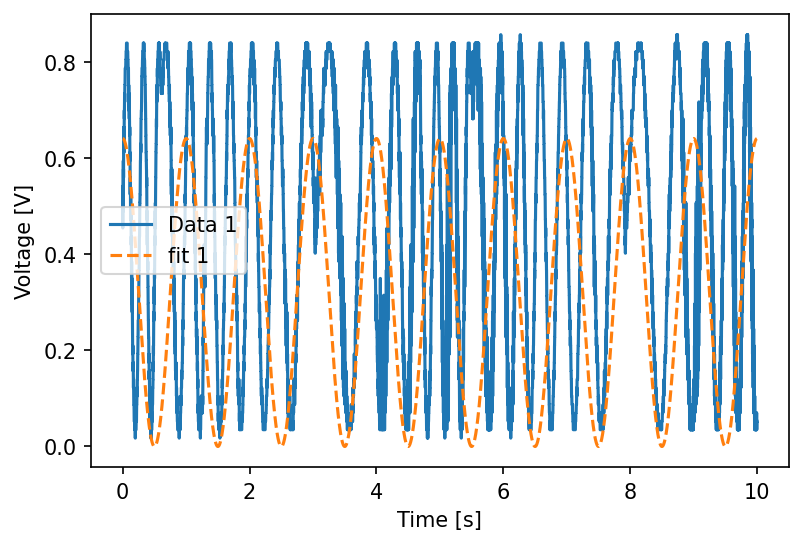

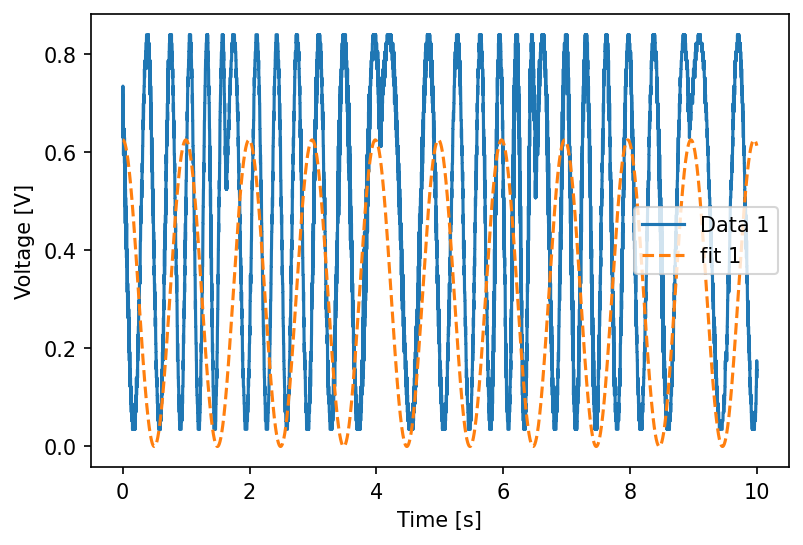

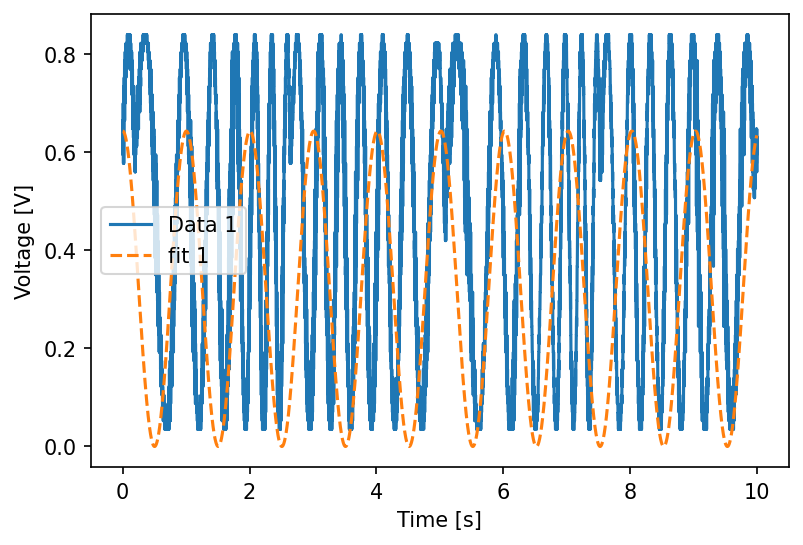

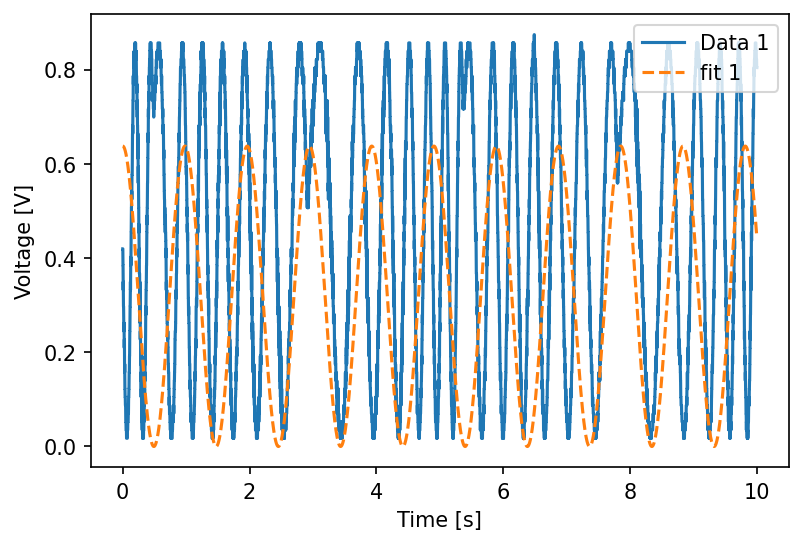

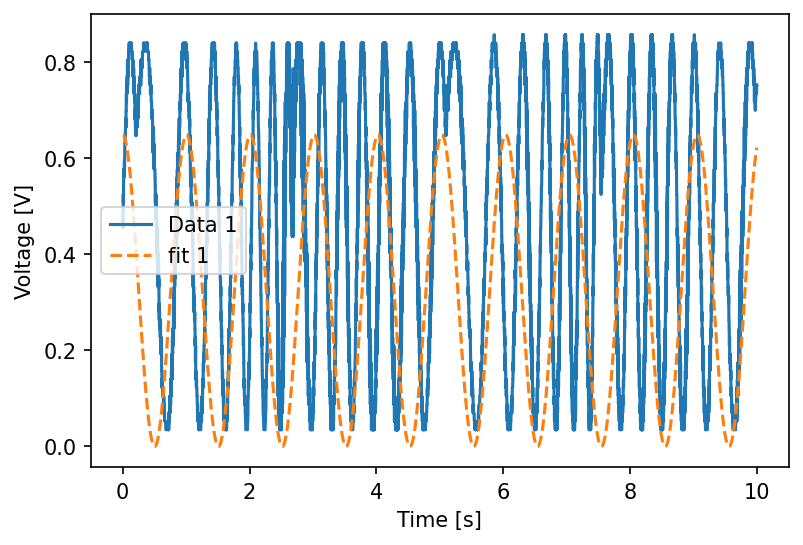

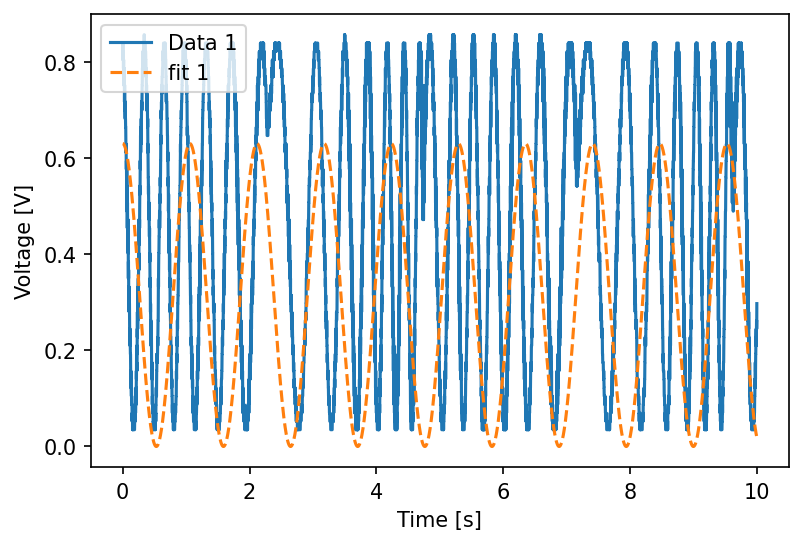

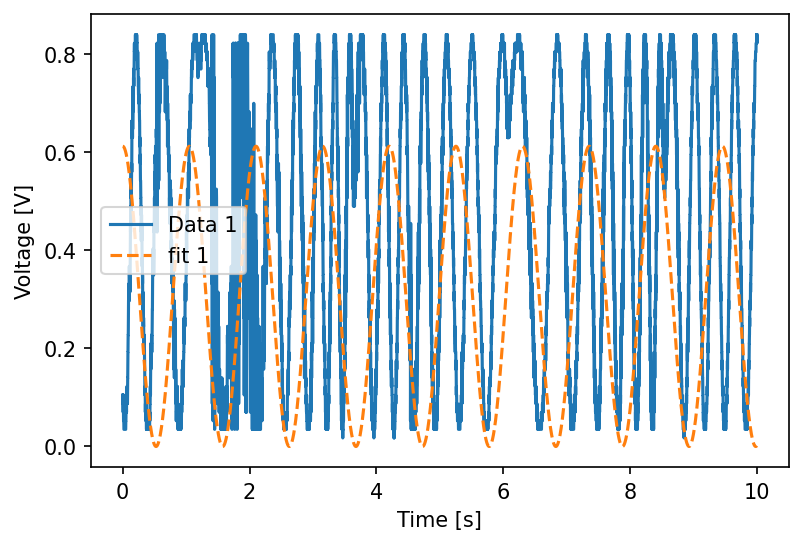

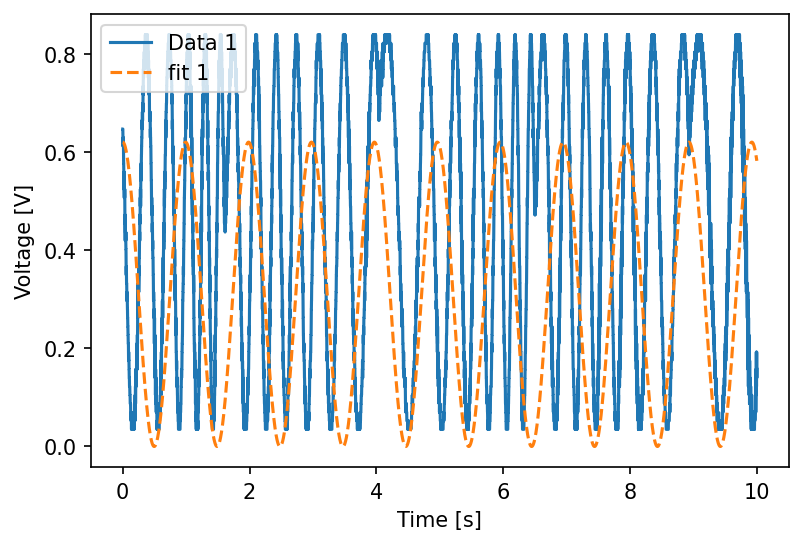

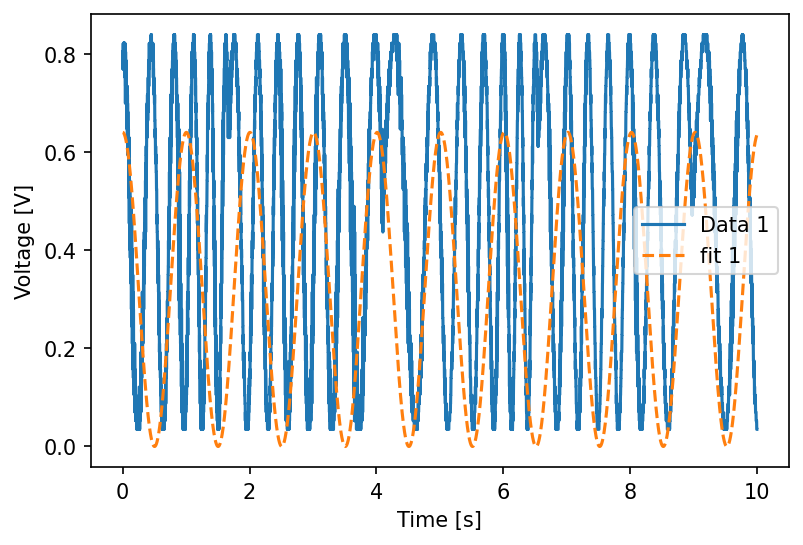

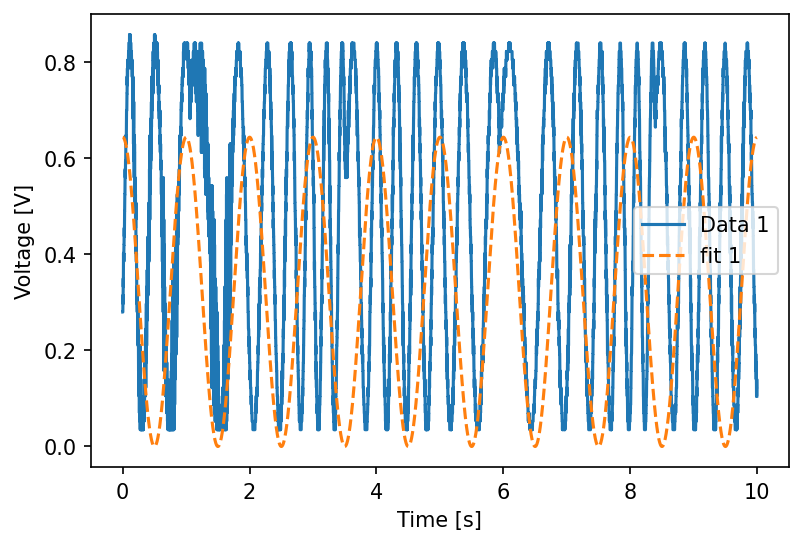

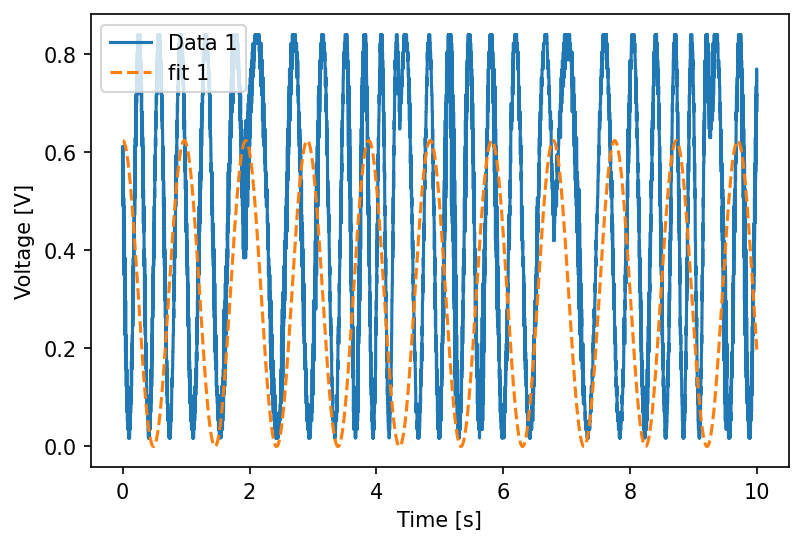

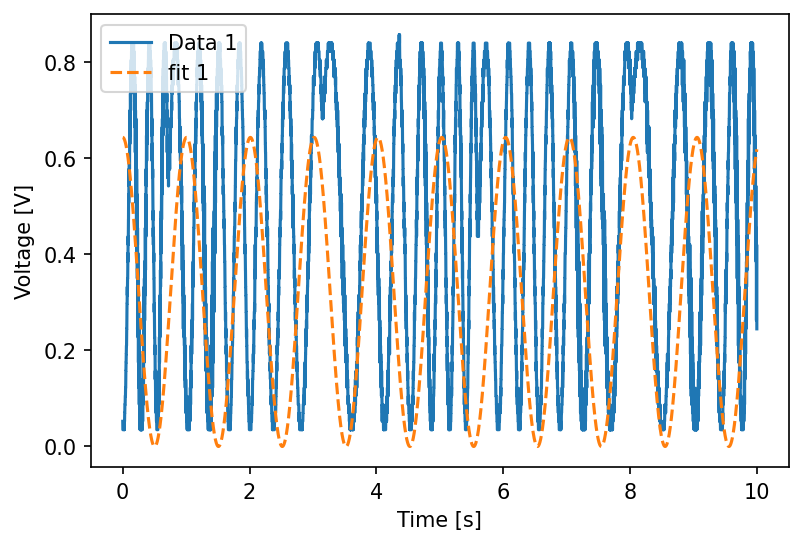

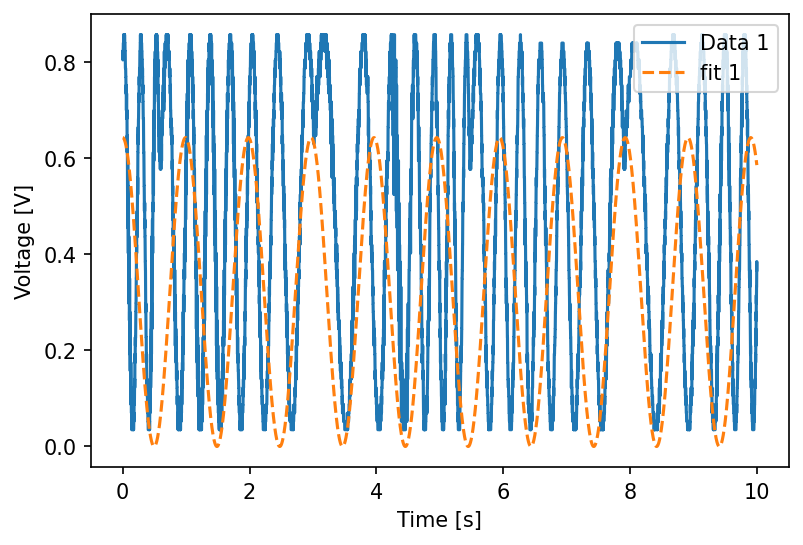

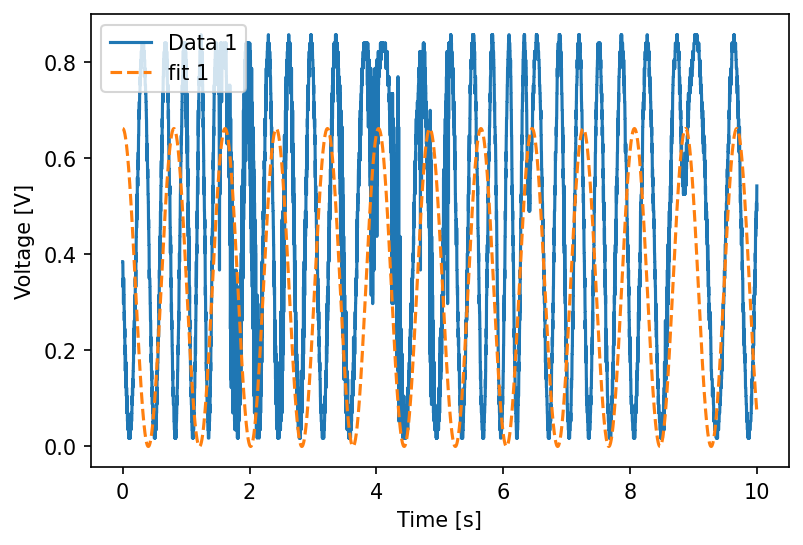

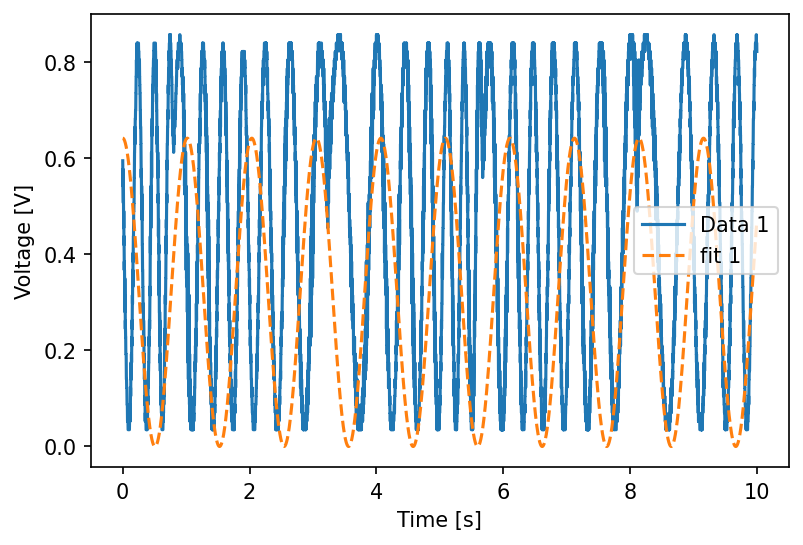

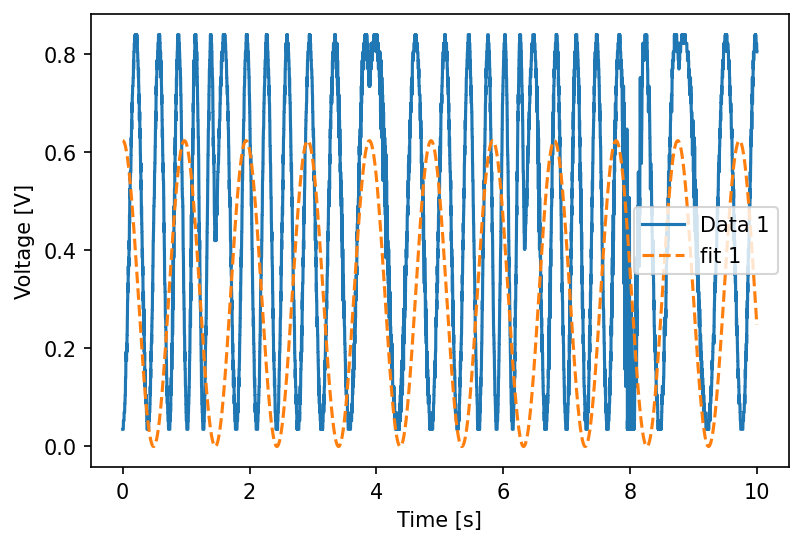

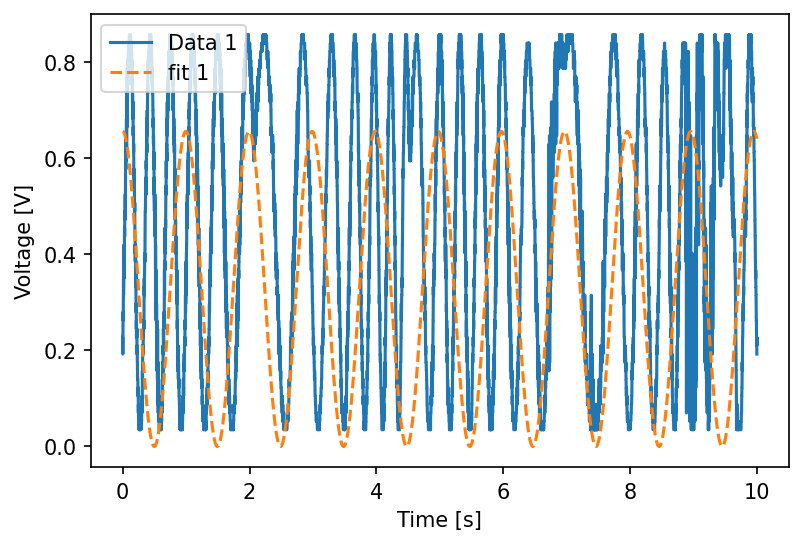

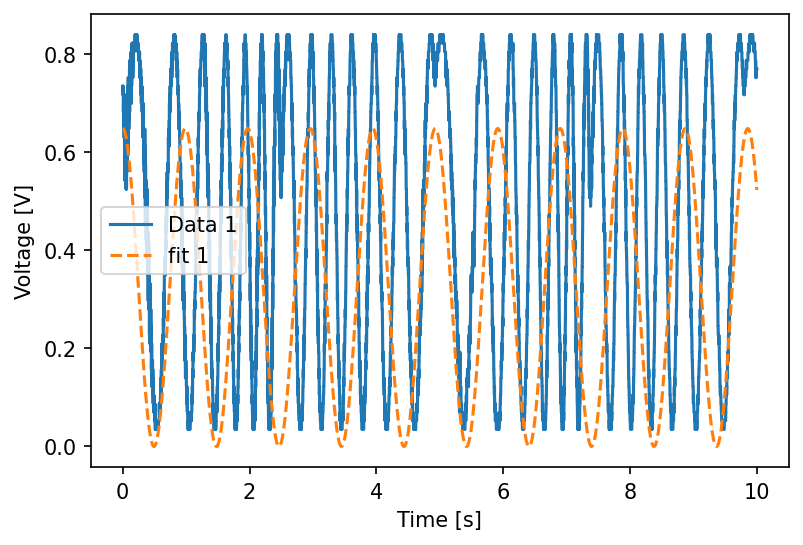

In [75]:
# Fit data and extract phase and amplitude

def Sine(t,*p): #define fitting function
    A=p[0]
    w=p[1]
    phi=p[2]
    C=p[3]
    return A*np.sin(w*t+phi)+C

# Create empty lists for saving
A1=[]
A2=[]
p1=[]
p2=[]
w1=[]
w2=[]
pcov_list2=[]

for Data,Data_name in zip(Data_list,Data_names):
    plt.figure() #plot raw data
    Time=Data[:,0]
    V1=Data[:,1]
    V2=Data[:,2]
    plt.plot(Time,V1, label='Data 1')
    #plt.plot(Time,V2, label='Data 2')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    
    #Do fit to first sine wave, make guesses on amplitide with max(V1)-min(V1), make guess based on frequency written in Data_name float(Data_name[24:27])
    popt1, pcov1 = sp.curve_fit(Intensity, Time, V1, p0=[a_guess, b_guess,0,0],bounds=([0,0,-np.pi,-2],[10,20,np.pi,20]))
    plt.plot(Time,Intensity(Time,*popt1),'--',label='fit 1')
    
    popt2, pcov2 = sp.curve_fit(Intensity, Time, V2, p0=[max(V2)-min(V2),2*np.pi,0,0],bounds=([0,0,-np.pi,-2],[10,20,np.pi,20]))
    A2.append(popt2[0])
    w2.append(popt2[1])
    p2.append(popt2[2])
    pcov_list2.append(pcov2)
    
    #plt.plot(Time,Intensity(Time,*popt2),'--',label='fit 2')
    
    plt.legend()
    
    

In [76]:
np.sqrt(pcov_list2)

/tmp/ipykernel_7016/1213520158.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(pcov_list2)


array([[[0.02549296,        nan, 0.        , 0.        ],
        [       nan, 0.00242575, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.02603866,        nan, 0.        , 0.        ],
        [       nan, 0.0024219 , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.02551803, 0.00107876, 0.        , 0.        ],
        [0.00107876, 0.00242171, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.02539814, 0.0003857 , 0.        , 0.        ],
        [0.0003857 , 0.00238899, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.02583779, 0.00020664, 0.        , 0.        ],
      